In [1]:
# This is used to increase the notebook's width to fill the screen, allowing for better plot visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import plot
from utils import split

C:\Users\leoar\AppData\Local\Temp\ipykernel_18968\2810647869.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# The STOIC Dataset

The STOIC Dataset (see https://pubs.rsna.org/doi/10.1148/radiol.2021210384 for a full description) contains Computed Tomography scans from 10,735 patients.  For this challenge, one CT scan from each patient has been selected, and the dataset has been divided randomly into a public training set (2,000 patients), a test set (~1,000 patients) and a private training set (7,000+ patients). The CT scans are stored as as mha files.

## Distribution
RT-PCR was positive for 6 448 subjects, corresponding to a disease prevalence of 60.0% during the study period. This includes subjects who had positive RT-PCR within the first week of presentation after a first negative test.

At 1- month follow-up, 964 patients had died (267 after intubation, 697 not intubated) and 611 were alive but had to be intubated at one point.

In total, 24% (1575/6448) of the COVID cases were severe (severity defined as either need for intubation at one point or death). The main goal of the STOIC2021 challenge is to predict from the CT scan who will develop severe disease. The secondary goal is to predict who had a positive RT-PCR.

Data comes from 20 different university hospitals from Paris and 5 other cities (Strasbourg, Lyon, Rennes, and Montpellier) in France;

## Clinical Data
The following information is available as headers in the mha files:

Age category (<40 years/40-50 years/50-60 years/60-70 years/70-80 years/ >80 years)
Gender: male/female
The following two outputs are available for each subject in the data set and need to be predicted:

RT-PCR results : binary
Outcome at 1 month : severe or non-severe (Severity defined as death or need for intubation)

## How to download the public training data
The public training set of 2000 CT scans is available on the Registry of Open Data on AWS. To download the public training set, please make sure that the latest version of the AWS CLI is installed on your system by following these instructions:

https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

With the AWS CLI installed, you can download the public training set (no AWS account required) by running:

aws s3 cp s3://stoic2021-training/ /path/to/destination/ --recursive --no-sign-request

If you have any difficulties downloading the data, please ask a question in the forum.

## [Source](https://stoic2021.grand-challenge.org/stoic-db/)

# Path to Dataset

In [2]:
# Relative path to dataset
data_dir = os.path.join( "..", "..", "..", "..", "Datasets", "COVID19", "Tomografia", "COVIDx CT-3A" )
assert os.path.exists( data_dir ), "Unable to find the relative path to COVIDx CT-3A, please check data_dir..."

#
dataset_name = "STOIC"

## Samples Dataframe

In [3]:
# Path to metadata csv
csv_path = os.path.join( data_dir, "combined_metadata.csv" )

# Reads metadata as dataframe, "age" column is treated as str since "N/A" can't be int
samples_df = pd.read_csv(csv_path, sep = ";", na_filter = False, dtype={"age": str})

samples_df.head()

,filename,patient_id,source,class,country,sex,age,partition,slice_selection,x_min,y_min,x_max,y_max,verified_finding,view,modality
0,NCP_96_1328_0032.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,9,94,512,405,Yes,Axial,CT
1,NCP_96_1328_0035.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,106,512,405,Yes,Axial,CT
2,NCP_96_1328_0036.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,105,512,406,Yes,Axial,CT
3,NCP_96_1328_0037.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,104,512,406,Yes,Axial,CT
4,NCP_96_1328_0038.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,103,512,406,Yes,Axial,CT


## Patients Dataframe

In [4]:
# Creates a new dataframe with metadata sorted by patient
patient_df = plot.convert_df_sample2patient( samples_df )

patient_df.head()

,patient_id,source,class,country,sex,age,partition,slice_selection,verified_finding,view,modality,sample_count
0,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,Yes,Axial,CT,121
1,NCP_270,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,124
2,NCP_322,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,40
3,NCP_1276,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,32
4,NCP_2683,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,9


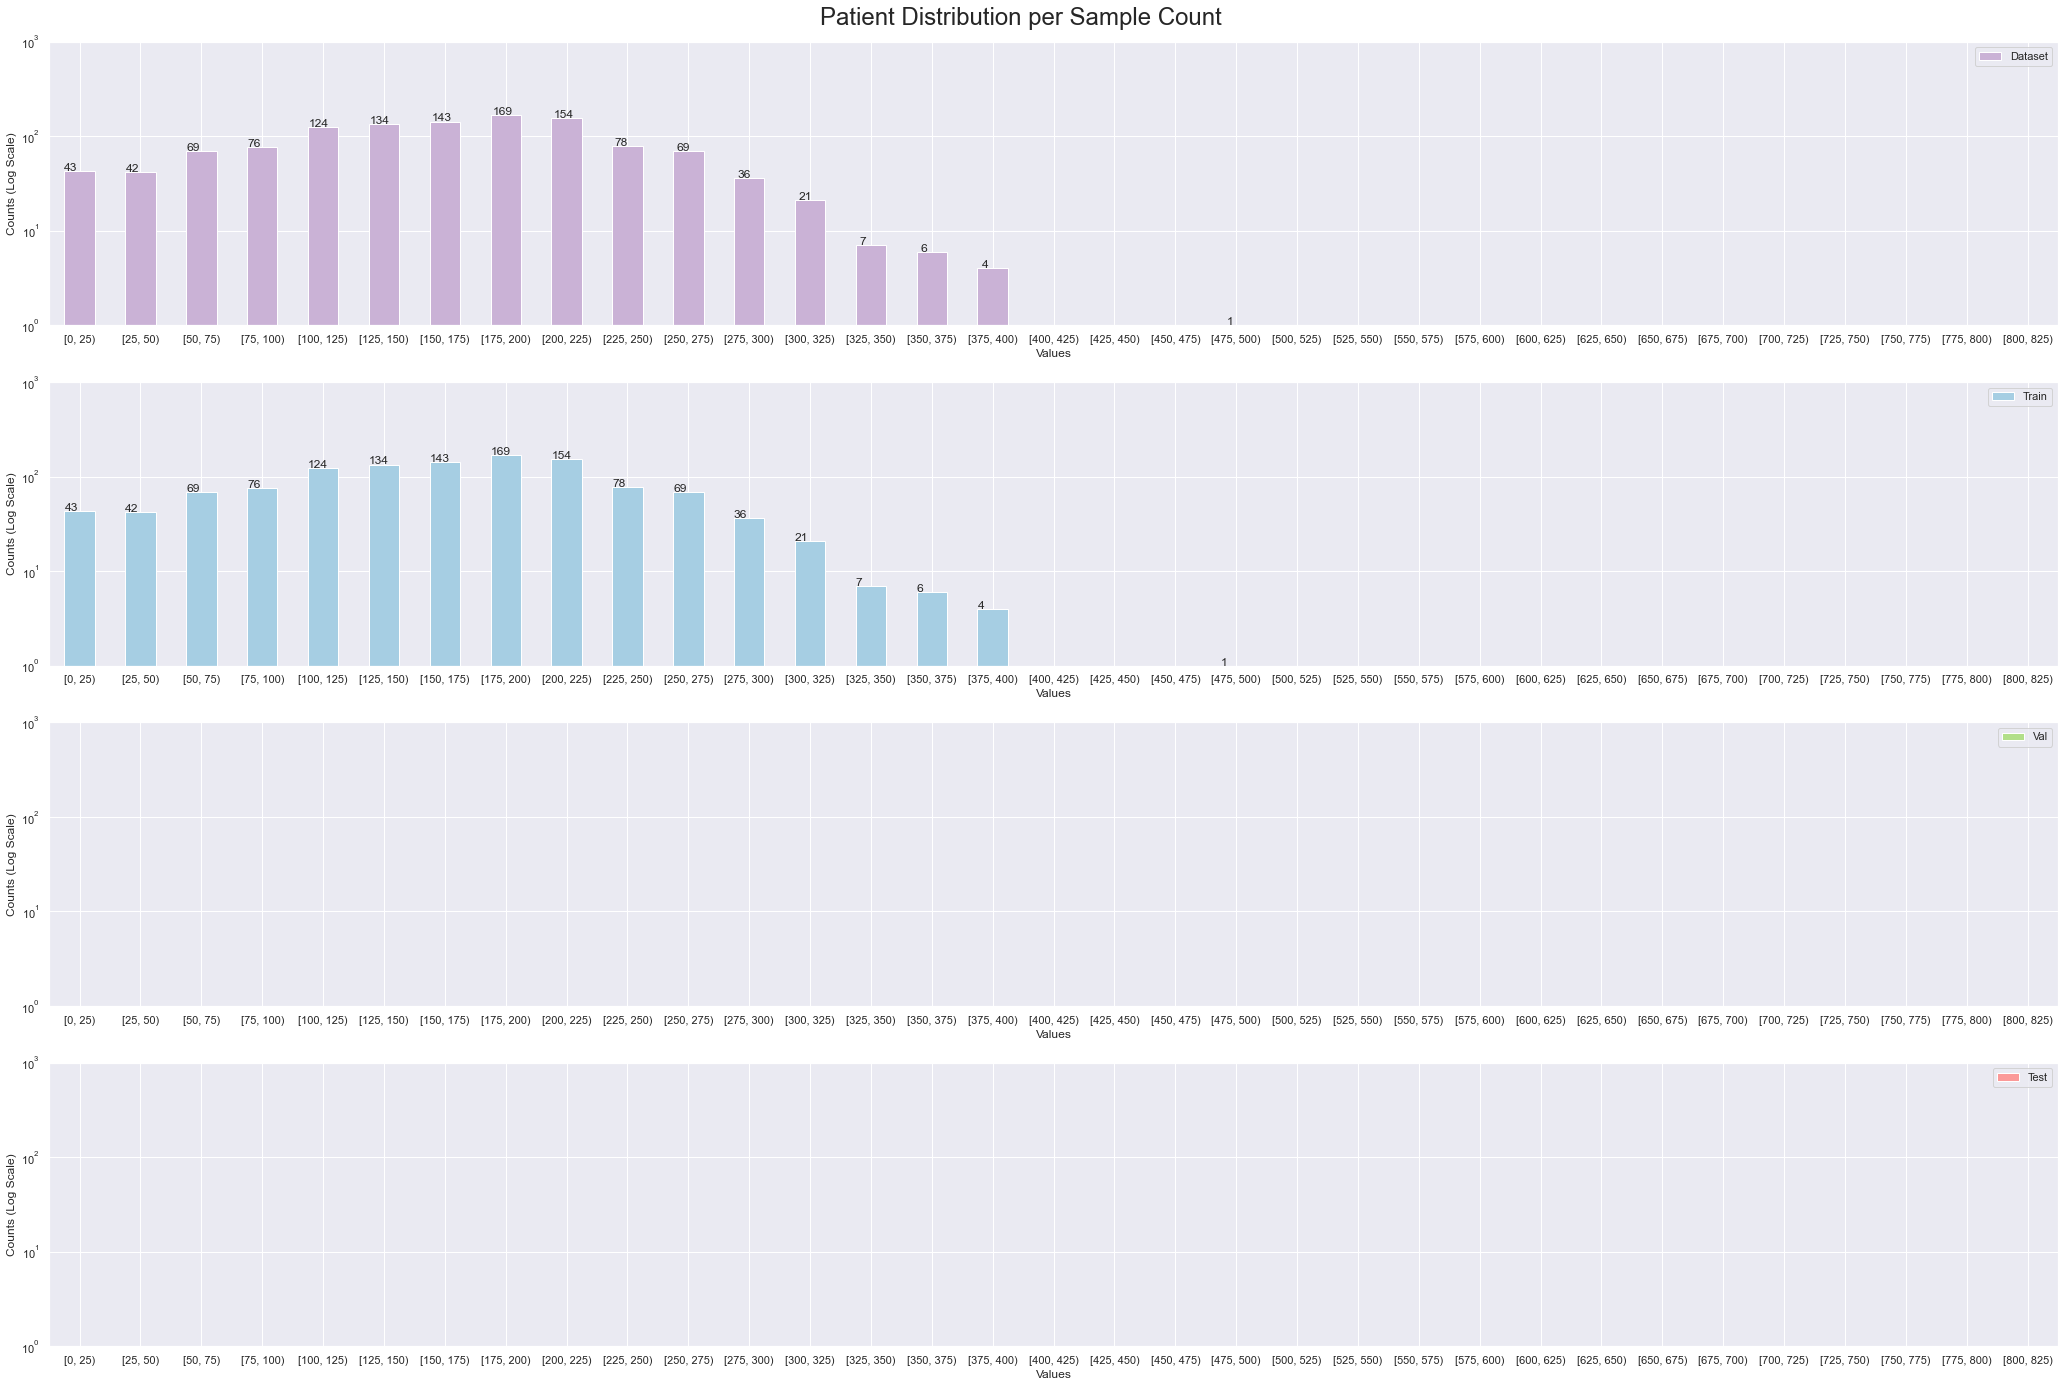

In [5]:
figure = plt.figure( figsize = (36, 24) )
plot.column_per_partition_as_histogram( patient_df, "sample_count", dataset_name, figure, title_complement = "Patient")

In [6]:
counts_df = plot.column_bins_per_partition_as_df( patient_df, "sample_count", dataset_name )
counts_df.head(len(counts_df))

,Dataset,Train,Val,Test
Values,,,,
"[0, 25)",43,43,0,0
"[25, 50)",42,42,0,0
"[50, 75)",69,69,0,0
"[75, 100)",76,76,0,0
"[100, 125)",124,124,0,0
"[125, 150)",134,134,0,0
"[150, 175)",143,143,0,0
"[175, 200)",169,169,0,0
"[200, 225)",154,154,0,0


# Plots

## Class

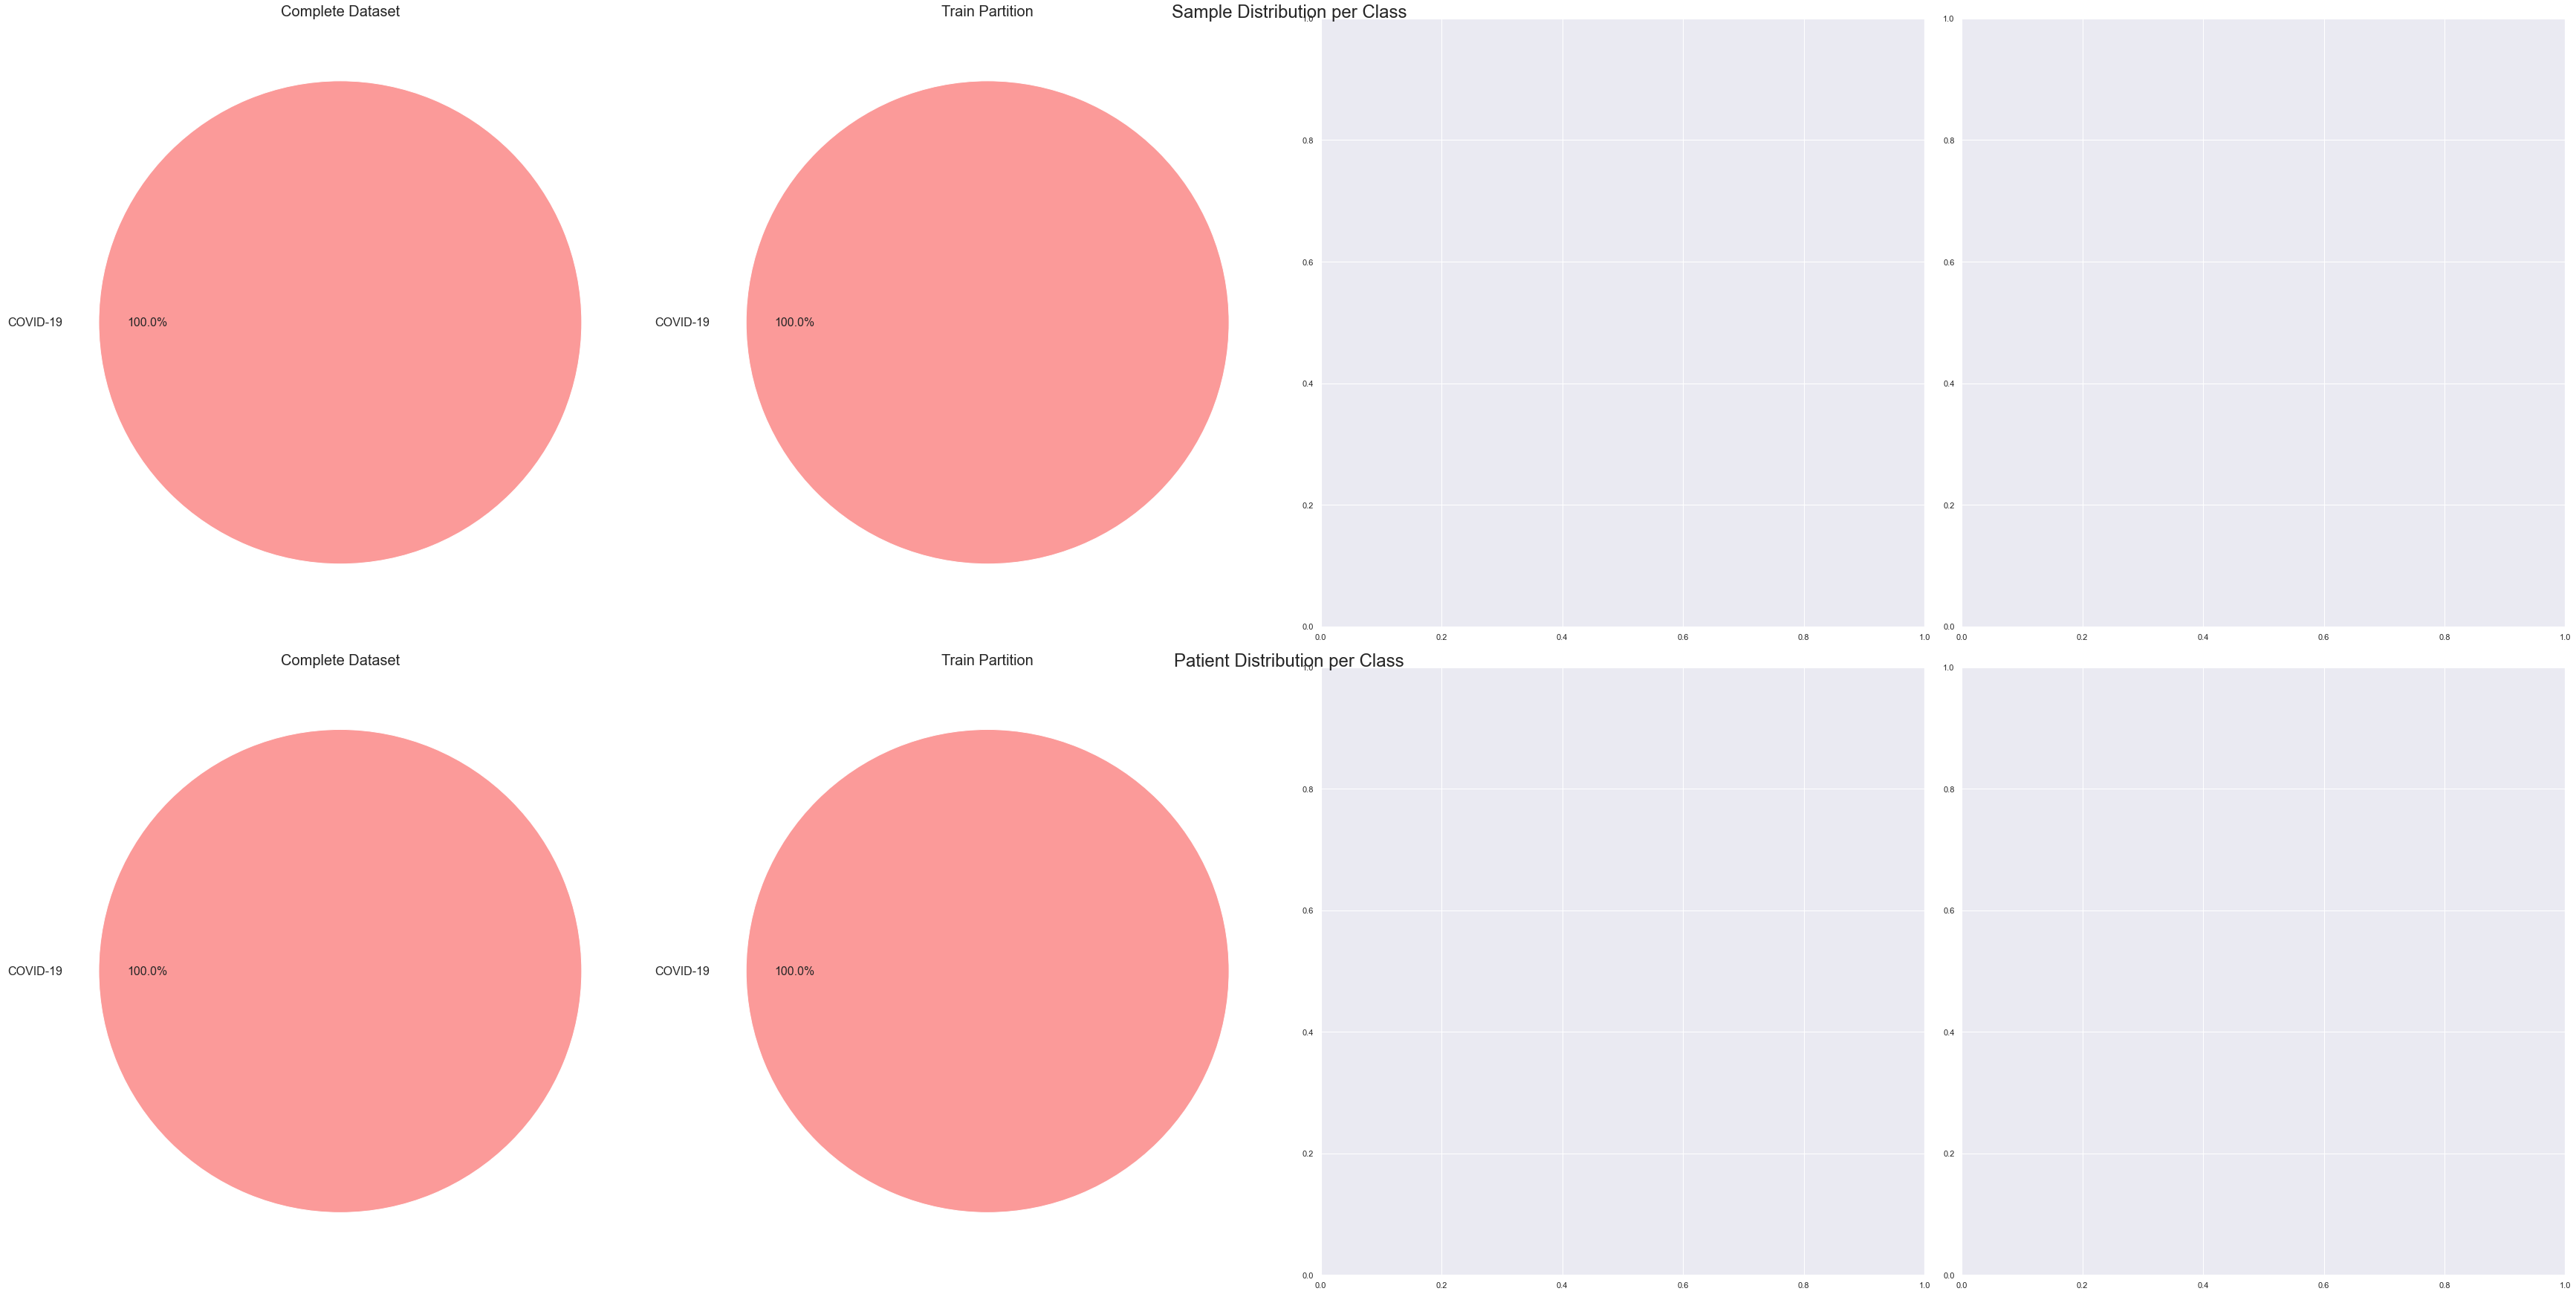

In [7]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [8]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
COVID-19,192361,192361,0,0
Normal,0,0,0,0
Pneumonia,0,0,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
COVID-19,1176,1176,0,0
Pneumonia,0,0,0,0
Normal,0,0,0,0


## Age

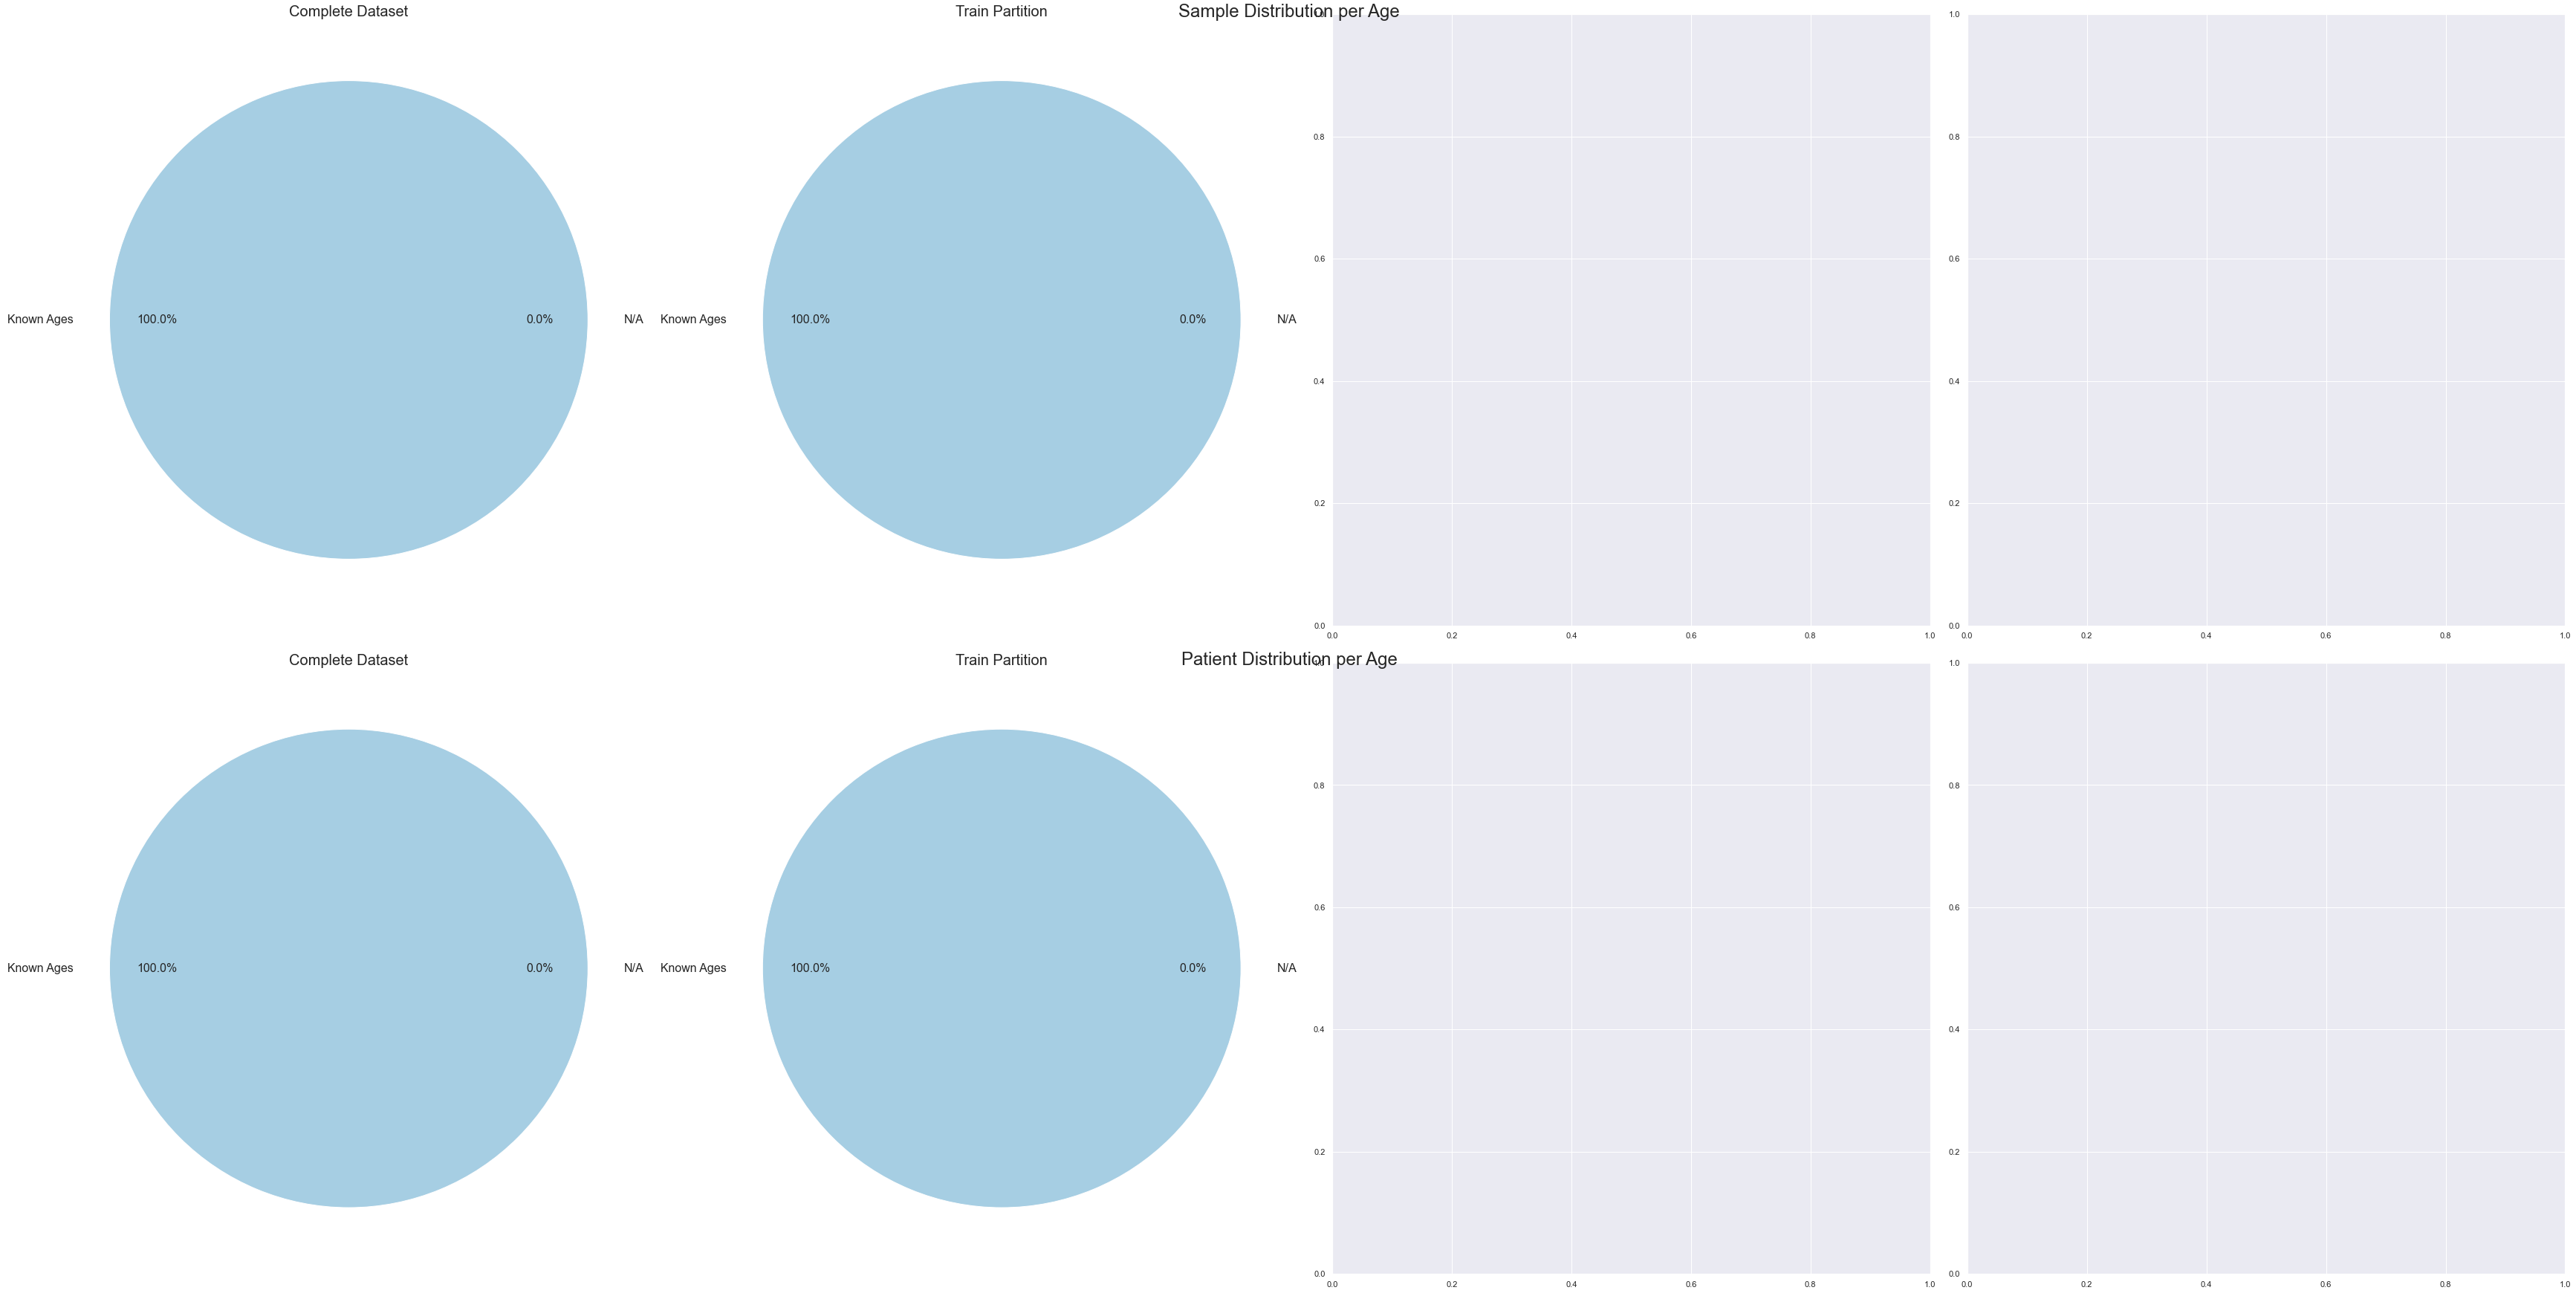

In [9]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [10]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
N/A,0,0,0,0
Known Ages,192361,192361,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
N/A,0,0,0,0
Known Ages,1176,1176,0,0
SUM,1176,1176,0,0


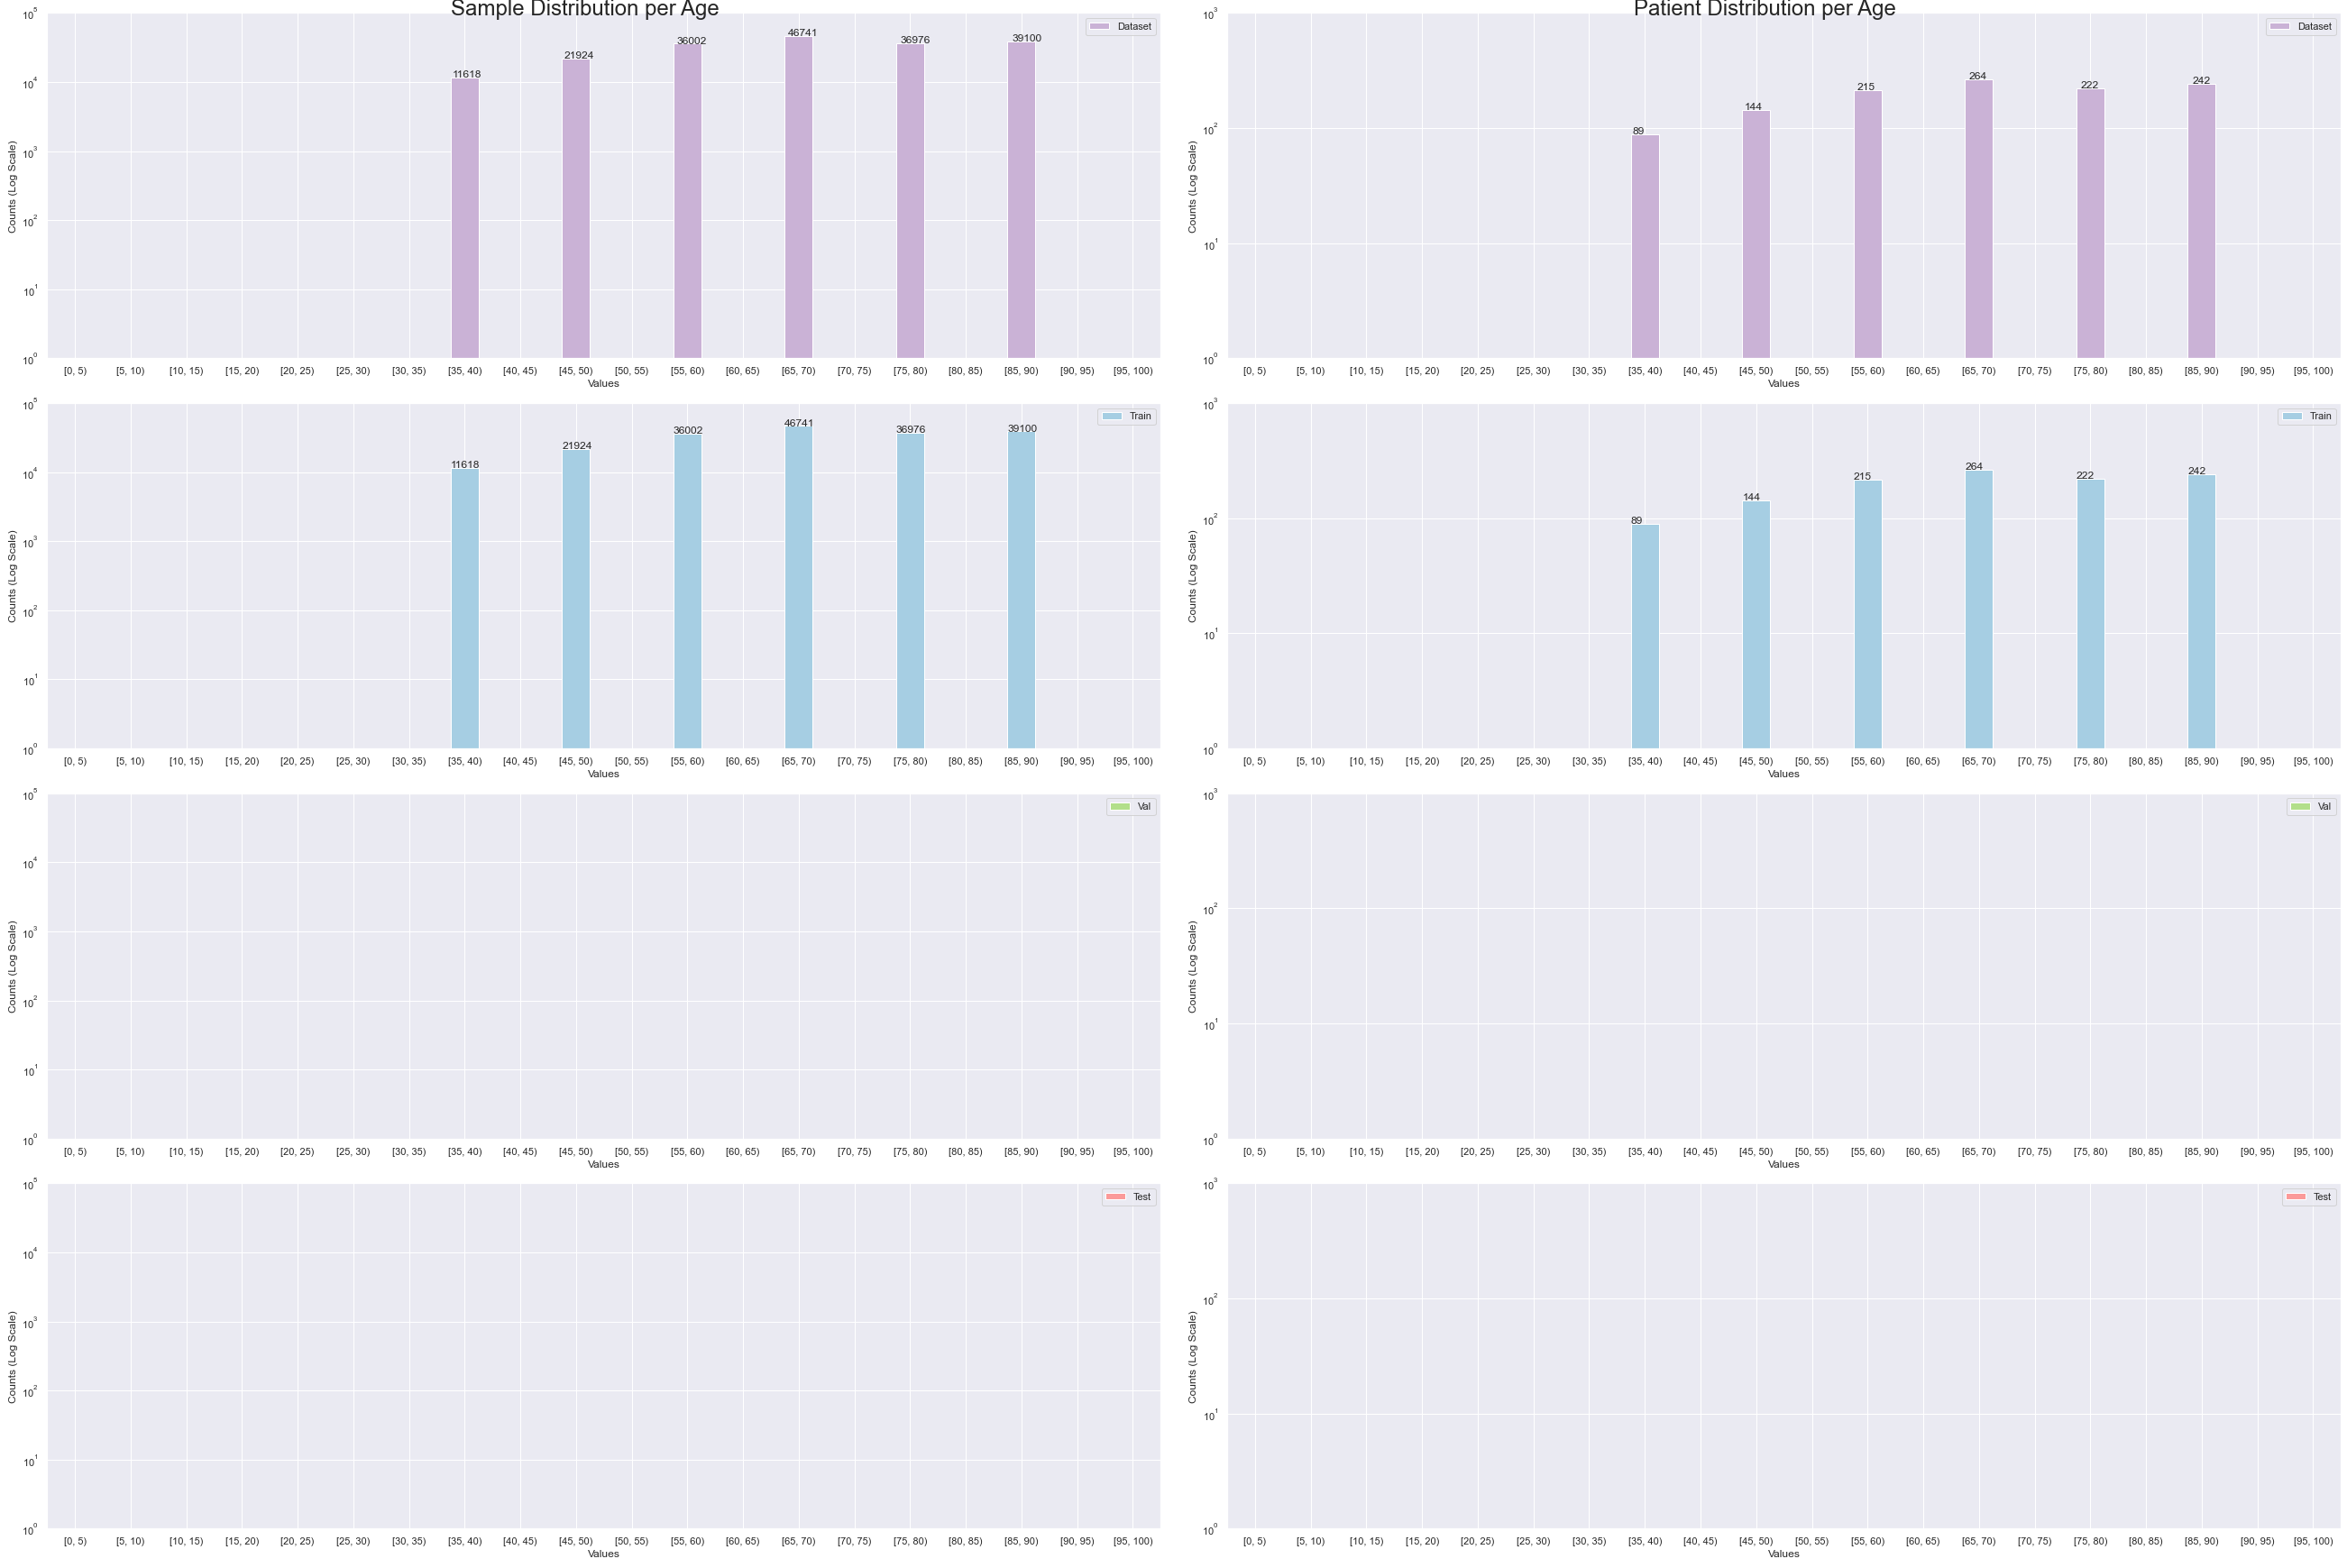

In [11]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [12]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

,Dataset,Train,Val,Test
Values,,,,
"[0, 5)",0,0,0,0
"[5, 10)",0,0,0,0
"[10, 15)",0,0,0,0
"[15, 20)",0,0,0,0
"[20, 25)",0,0,0,0
"[25, 30)",0,0,0,0
"[30, 35)",0,0,0,0
"[35, 40)",11618,11618,0,0
"[40, 45)",0,0,0,0


## Sex

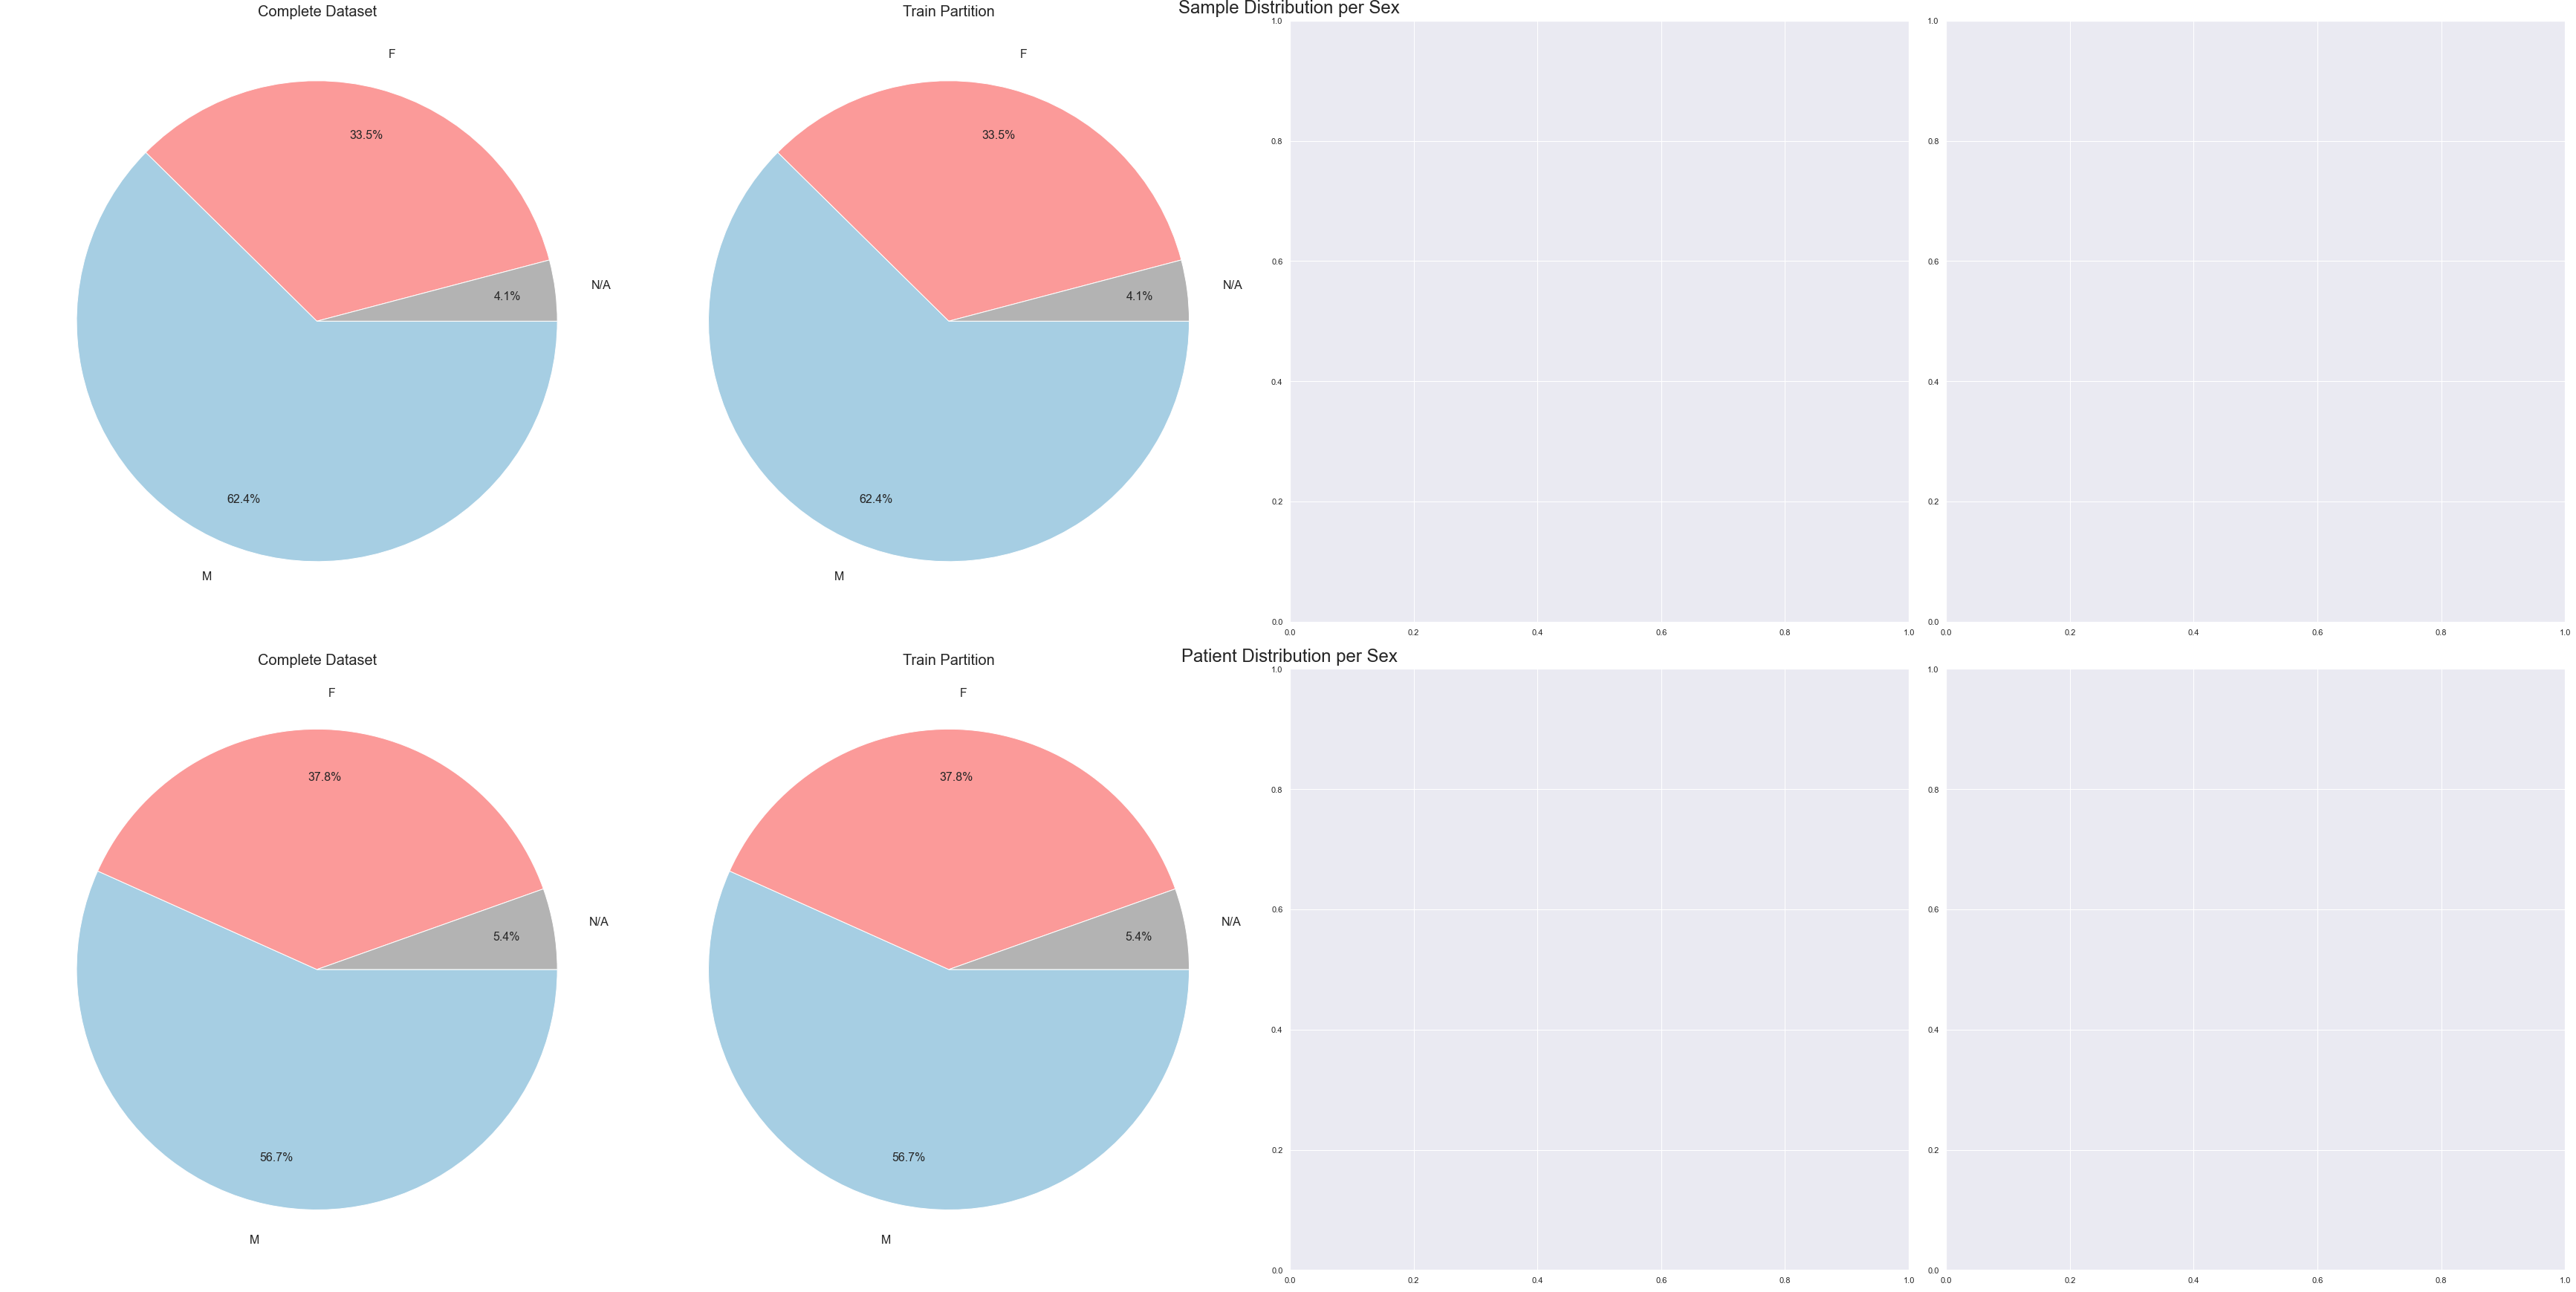

In [13]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [14]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
M,120016,120016,0,0
N/A,7879,7879,0,0
F,64466,64466,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
N/A,64,64,0,0
M,667,667,0,0
F,445,445,0,0


## Country

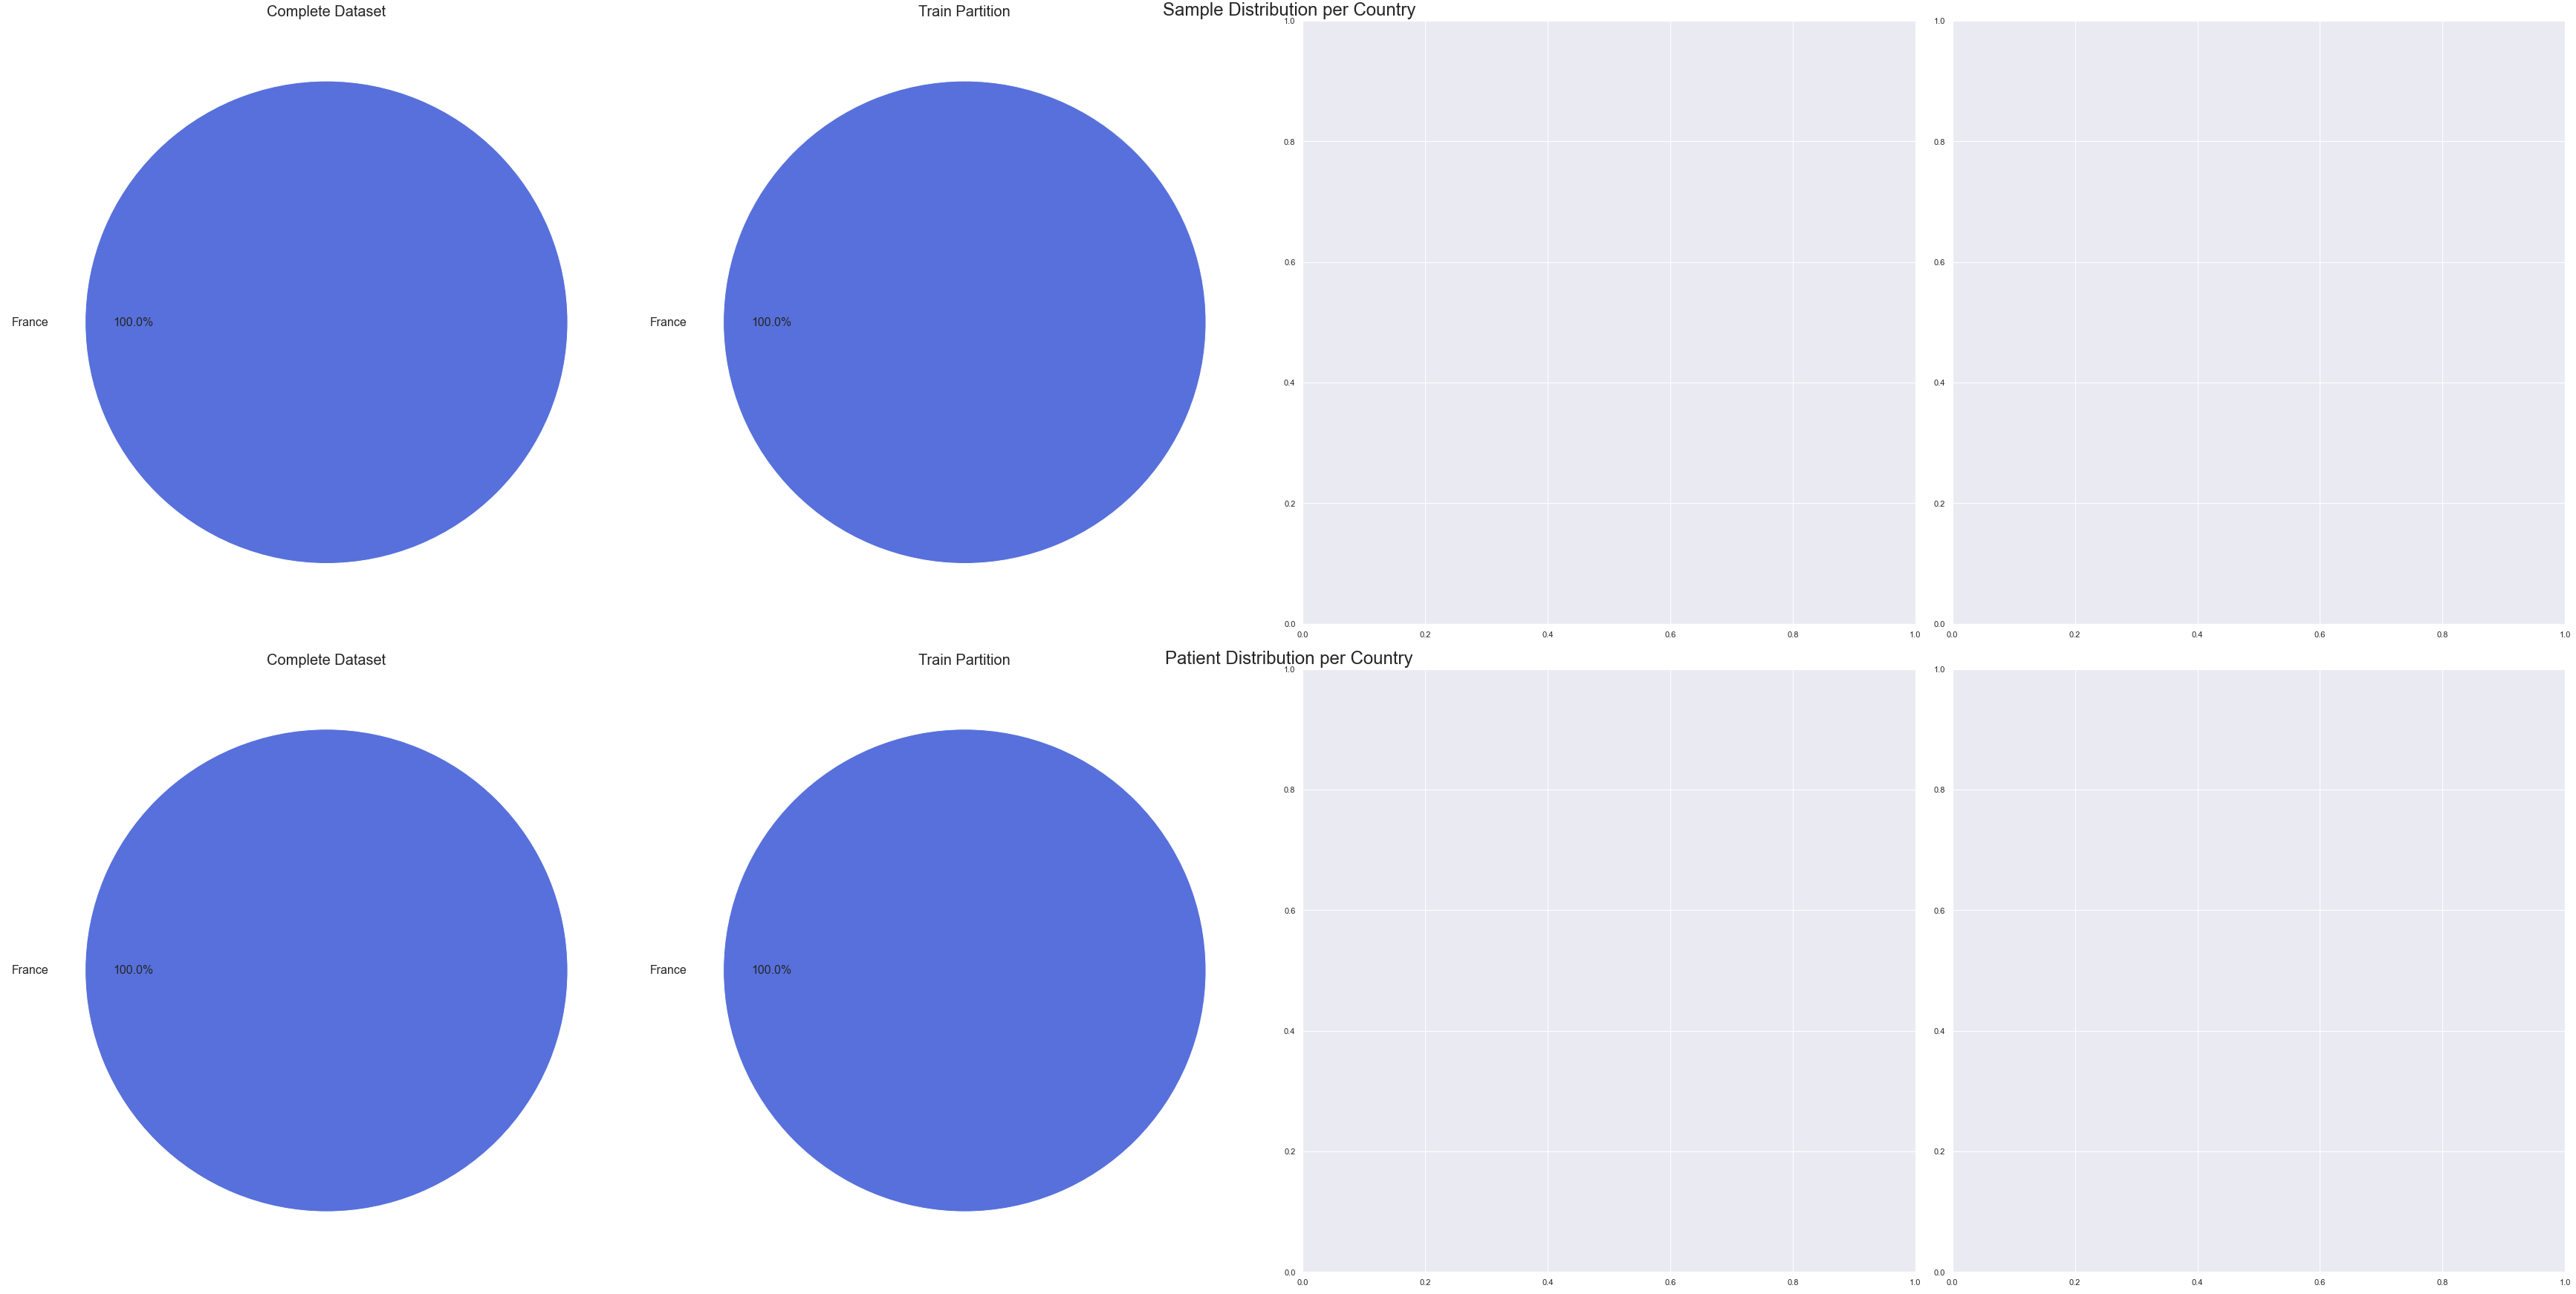

In [15]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [16]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
France,192361,192361,0,0
China,0,0,0,0
Iran,0,0,0,0
USA,0,0,0,0
N/A,0,0,0,0
Australia,0,0,0,0
Italy,0,0,0,0
Algeria,0,0,0,0
Belgium,0,0,0,0


## Partition

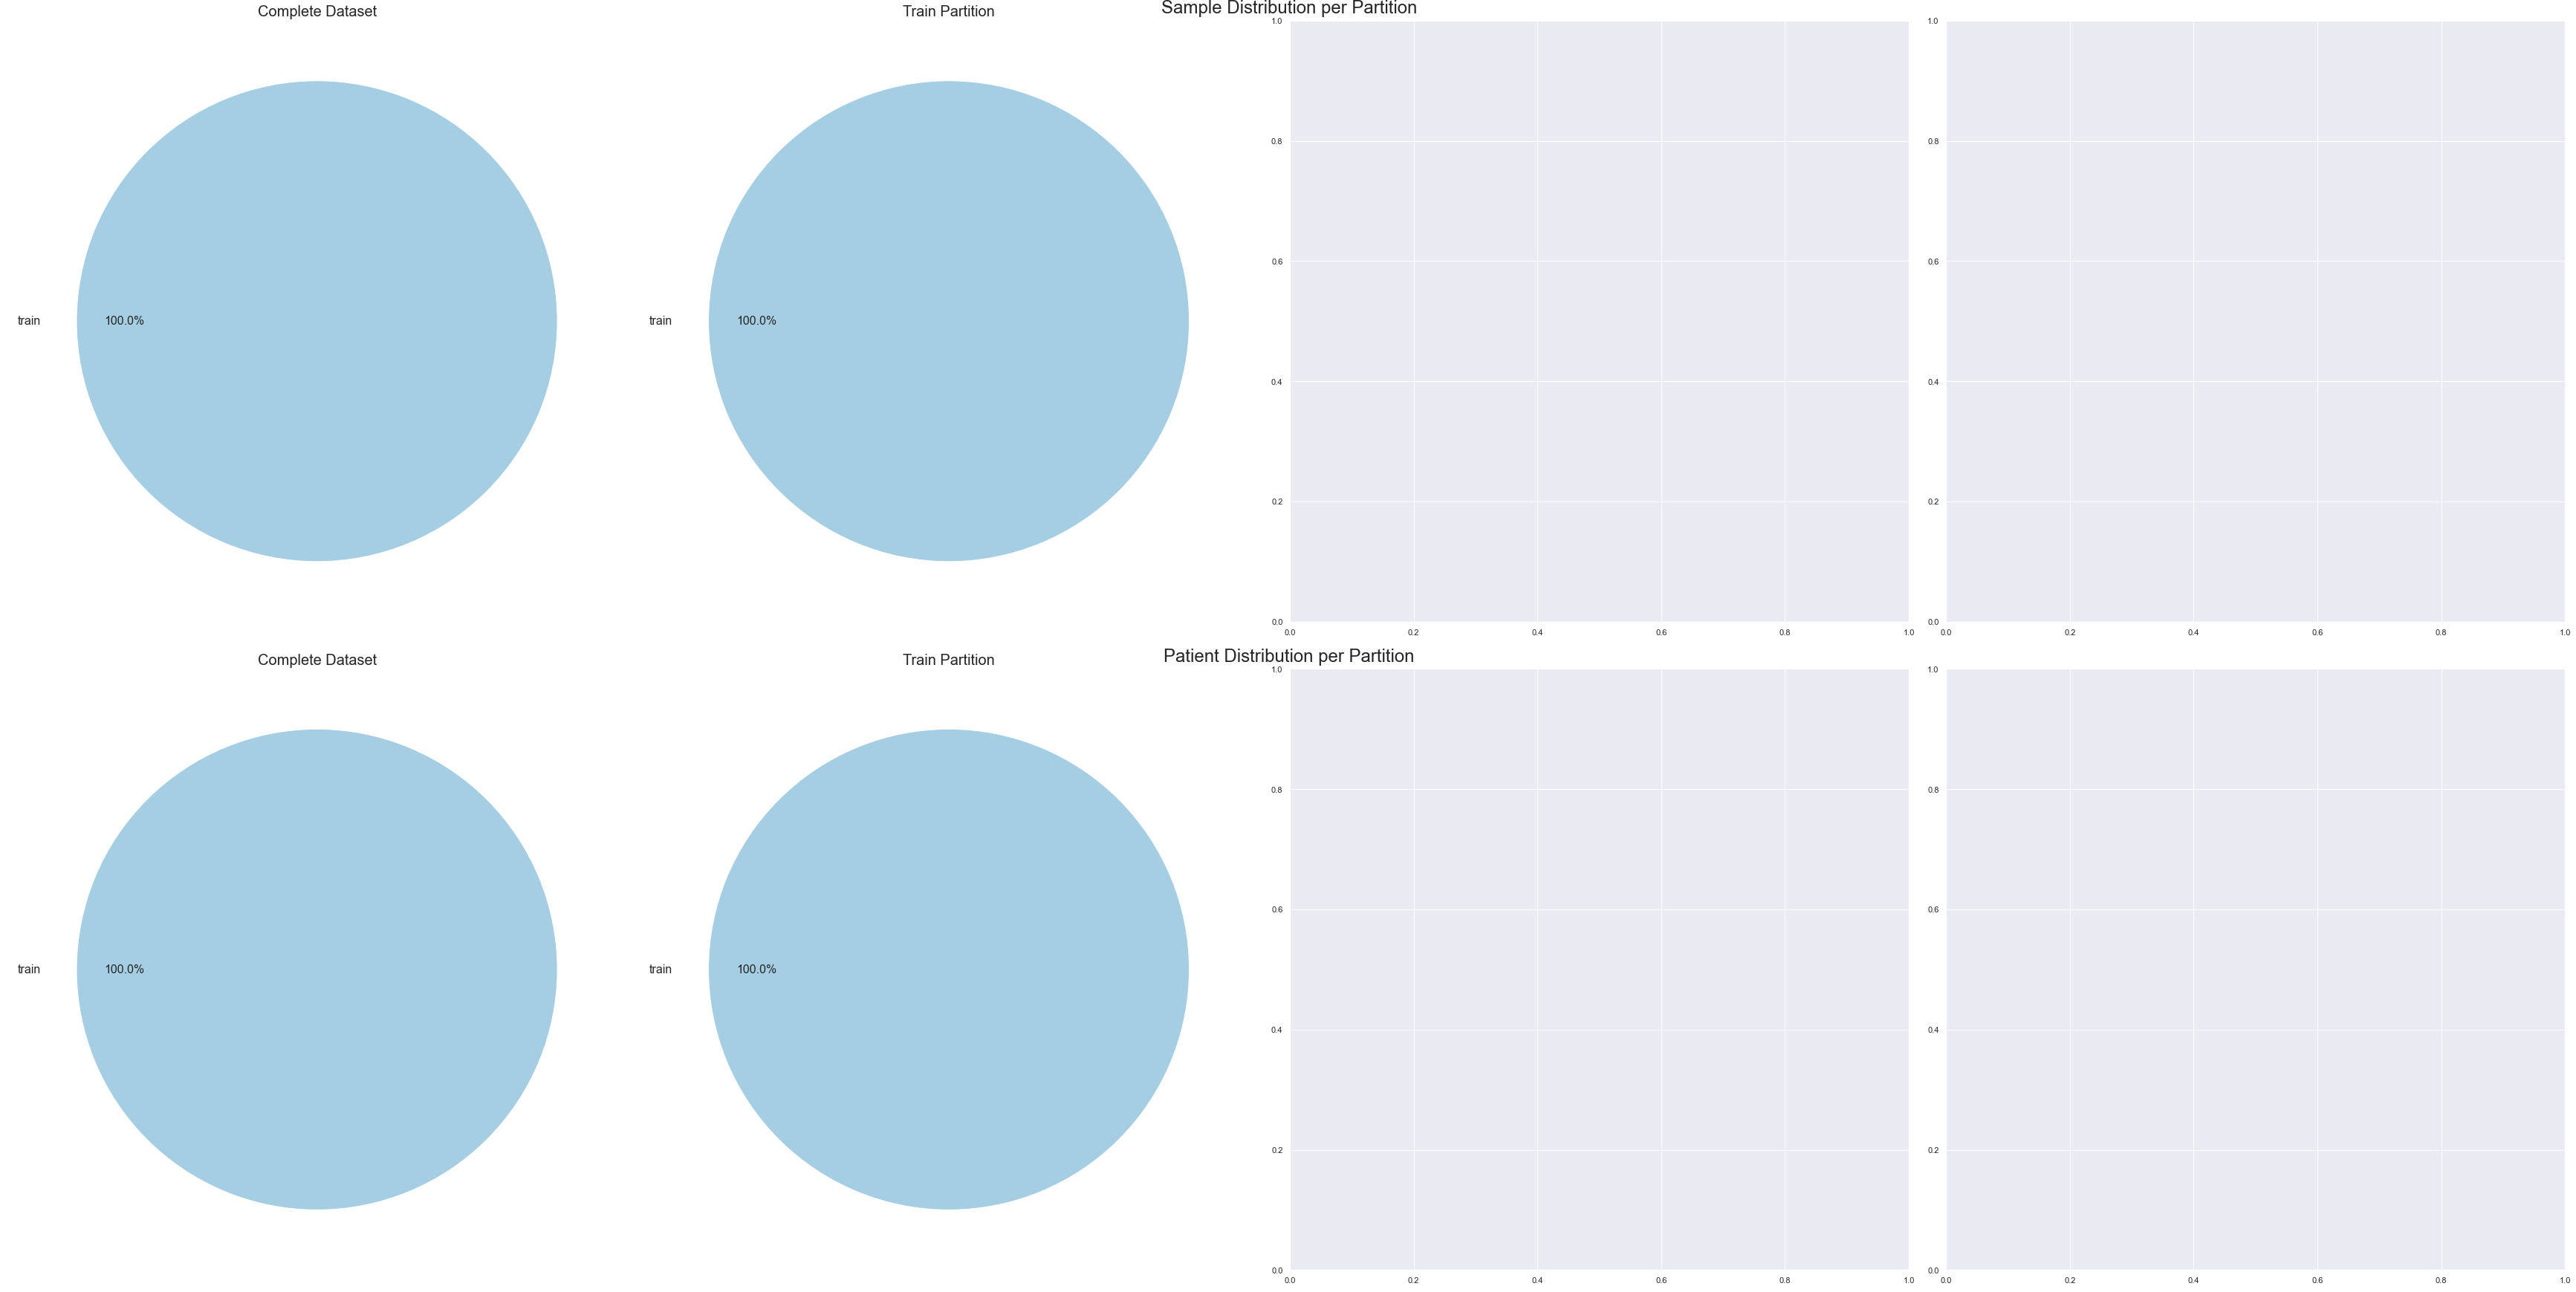

In [17]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [18]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
train,192361,192361,0,0
test,0,0,0,0
val,0,0,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
train,1176,1176,0,0
val,0,0,0,0
test,0,0,0,0


## Slice Selection

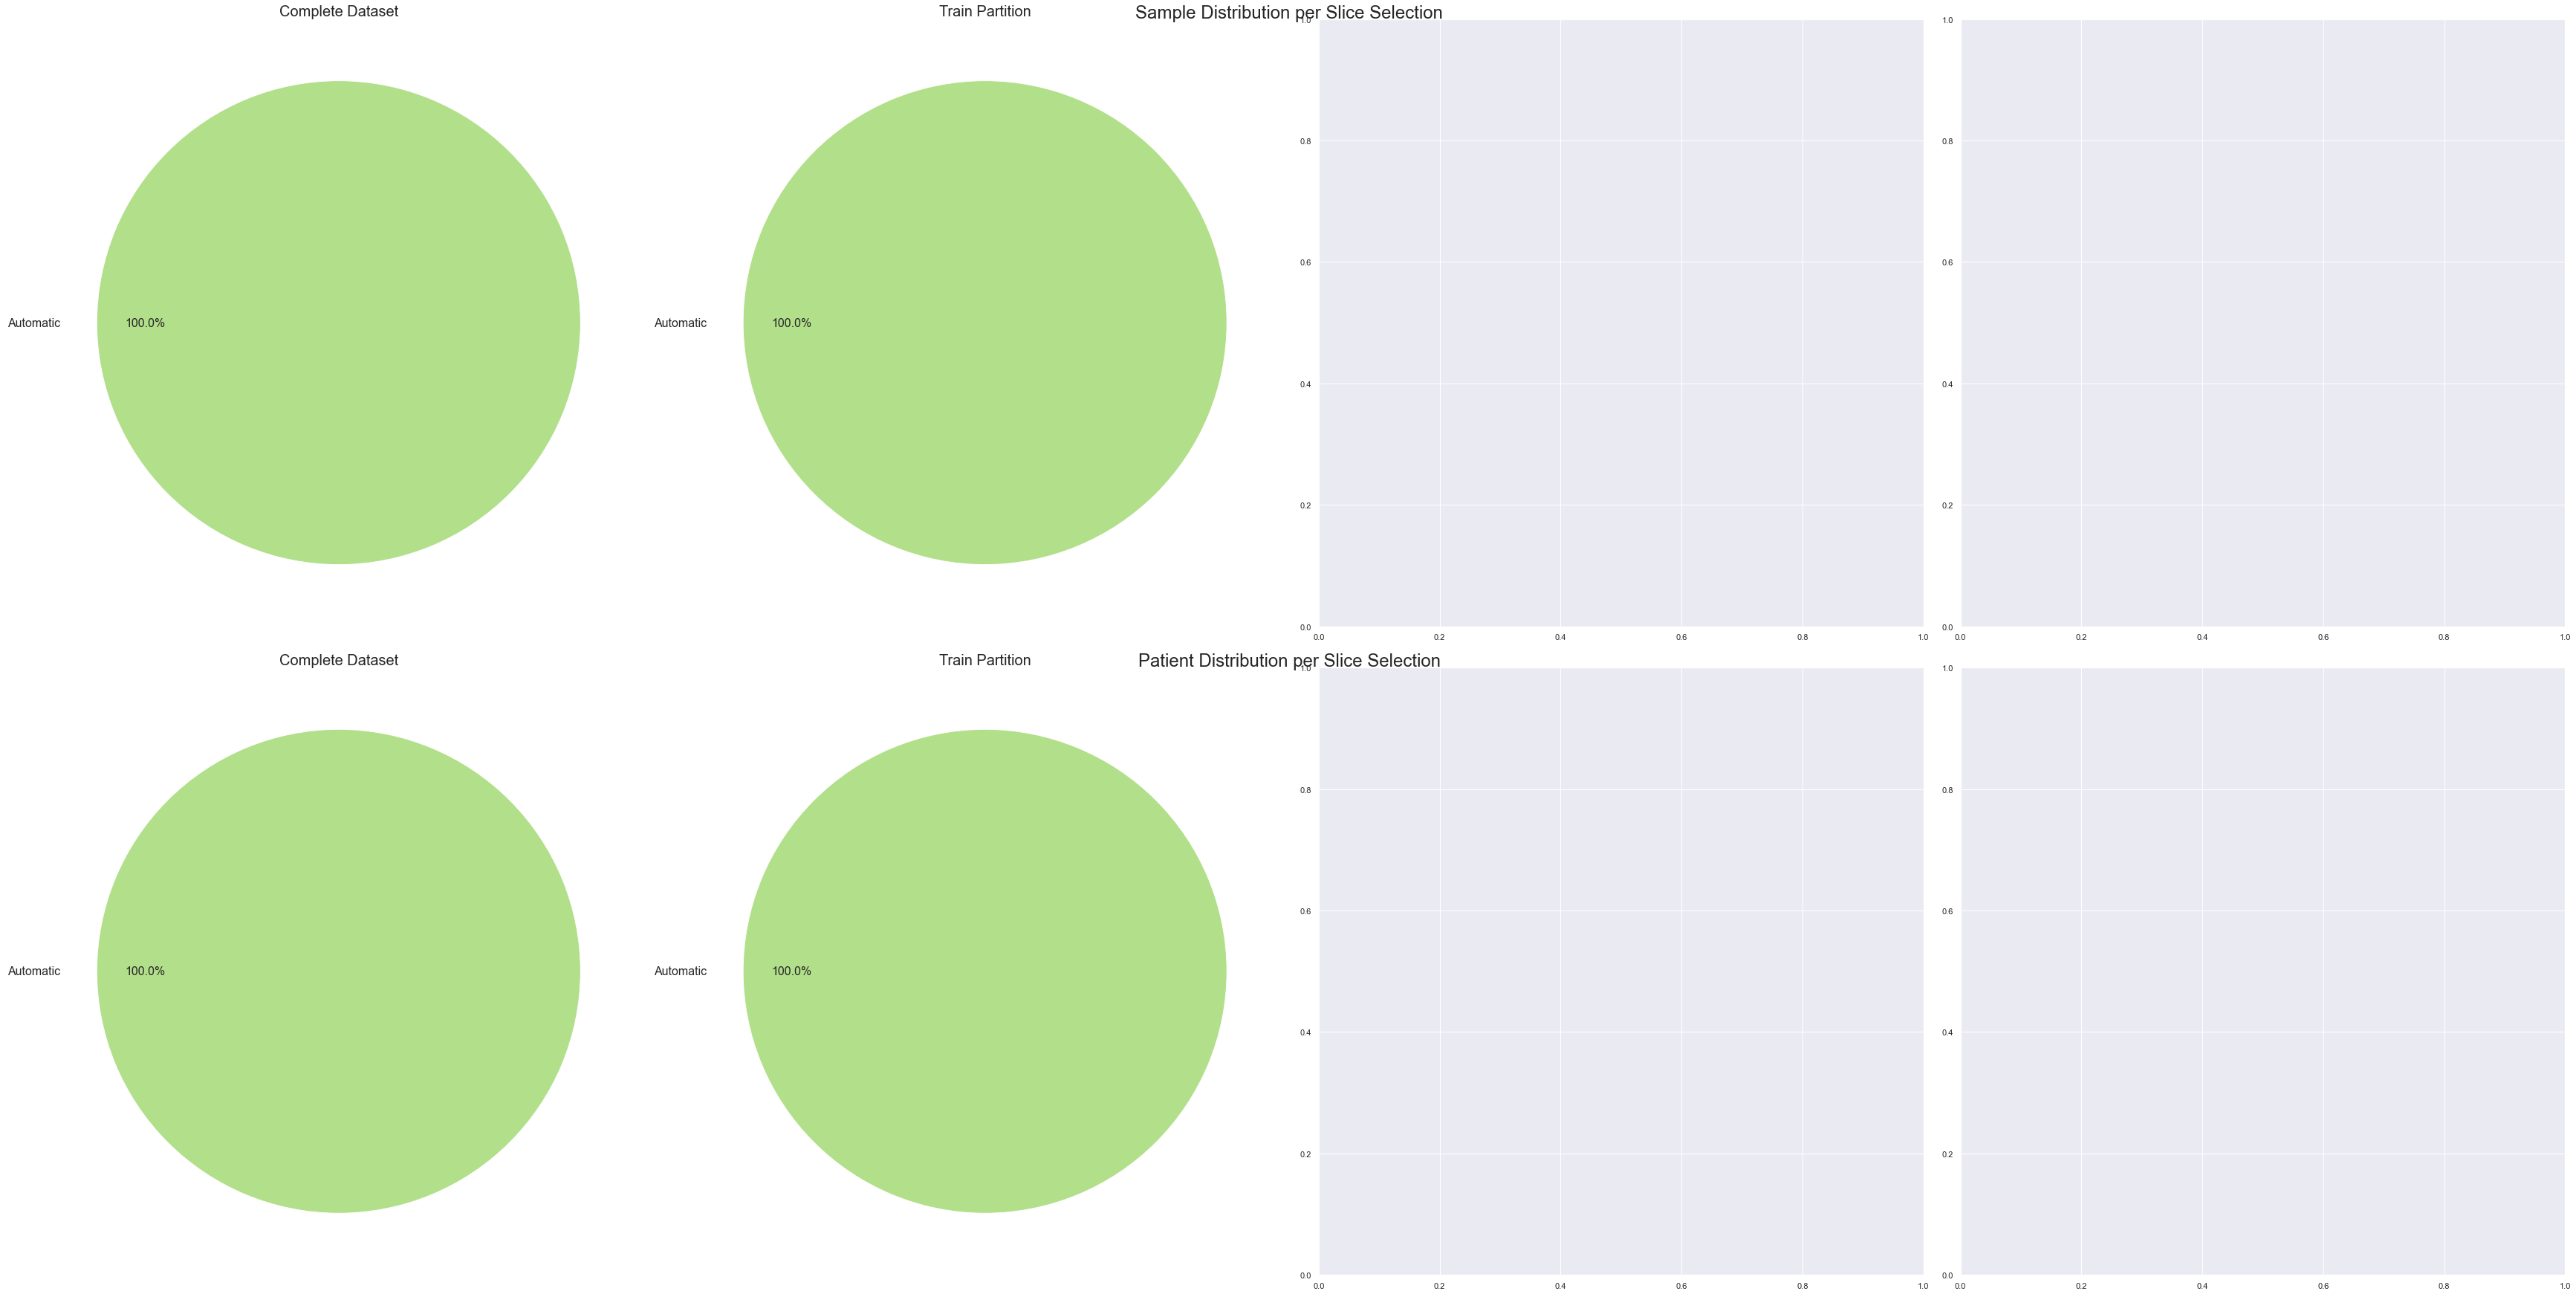

In [19]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [20]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
Automatic,192361,192361,0,0
Expert,0,0,0,0
N/A,0,0,0,0
Non-expert,0,0,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
Automatic,1176,1176,0,0
Expert,0,0,0,0


# Data Split

In [21]:
new_samples_df, new_patient_df = split.radiopaedia_dataset_by_samples( samples_df, patient_df, dataset_name, sample_frac = 0.2, seed = 20 )

    1/1: Group ('N/A', 'COVID-19', 'Automatic', 'N/A', 'N/A')
	[Test] Moved 38472 samples (231 patients), expected 38472 samples, had 192361 samples (1176 patients)...
		List of sample counts: [255, 296, 269, 64, 244, 195, 54, 158, 58, 10, 193, 74, 188, 171, 154, 221, 135, 258, 68, 209, 2, 150, 218, 36, 184, 45, 310, 206, 145, 263, 105, 139, 220, 156, 212, 179, 59, 92, 203, 163, 303, 119, 253, 11, 80, 185, 227, 115, 126, 201, 227, 273, 162, 50, 226, 163, 101, 259, 104, 239, 164, 269, 105, 193, 216, 197, 196, 238, 125, 190, 231, 212, 199, 272, 214, 76, 24, 363, 175, 209, 153, 179, 102, 116, 104, 260, 215, 156, 76, 17, 134, 156, 141, 173, 224, 26, 81, 114, 165, 70, 151, 123, 55, 240, 294, 1, 203, 79, 184, 272, 20, 8, 44, 334, 92, 113, 223, 190, 215, 262, 88, 297, 201, 257, 51, 75, 54, 98, 178, 124, 302, 206, 139, 284, 208, 243, 212, 218, 269, 184, 194, 52, 176, 221, 212, 157, 85, 190, 227, 72, 173, 281, 118, 128, 185, 79, 160, 280, 184, 104, 153, 180, 168, 143, 36, 182, 98, 253, 157, 100

# Post Split Plots

## Class

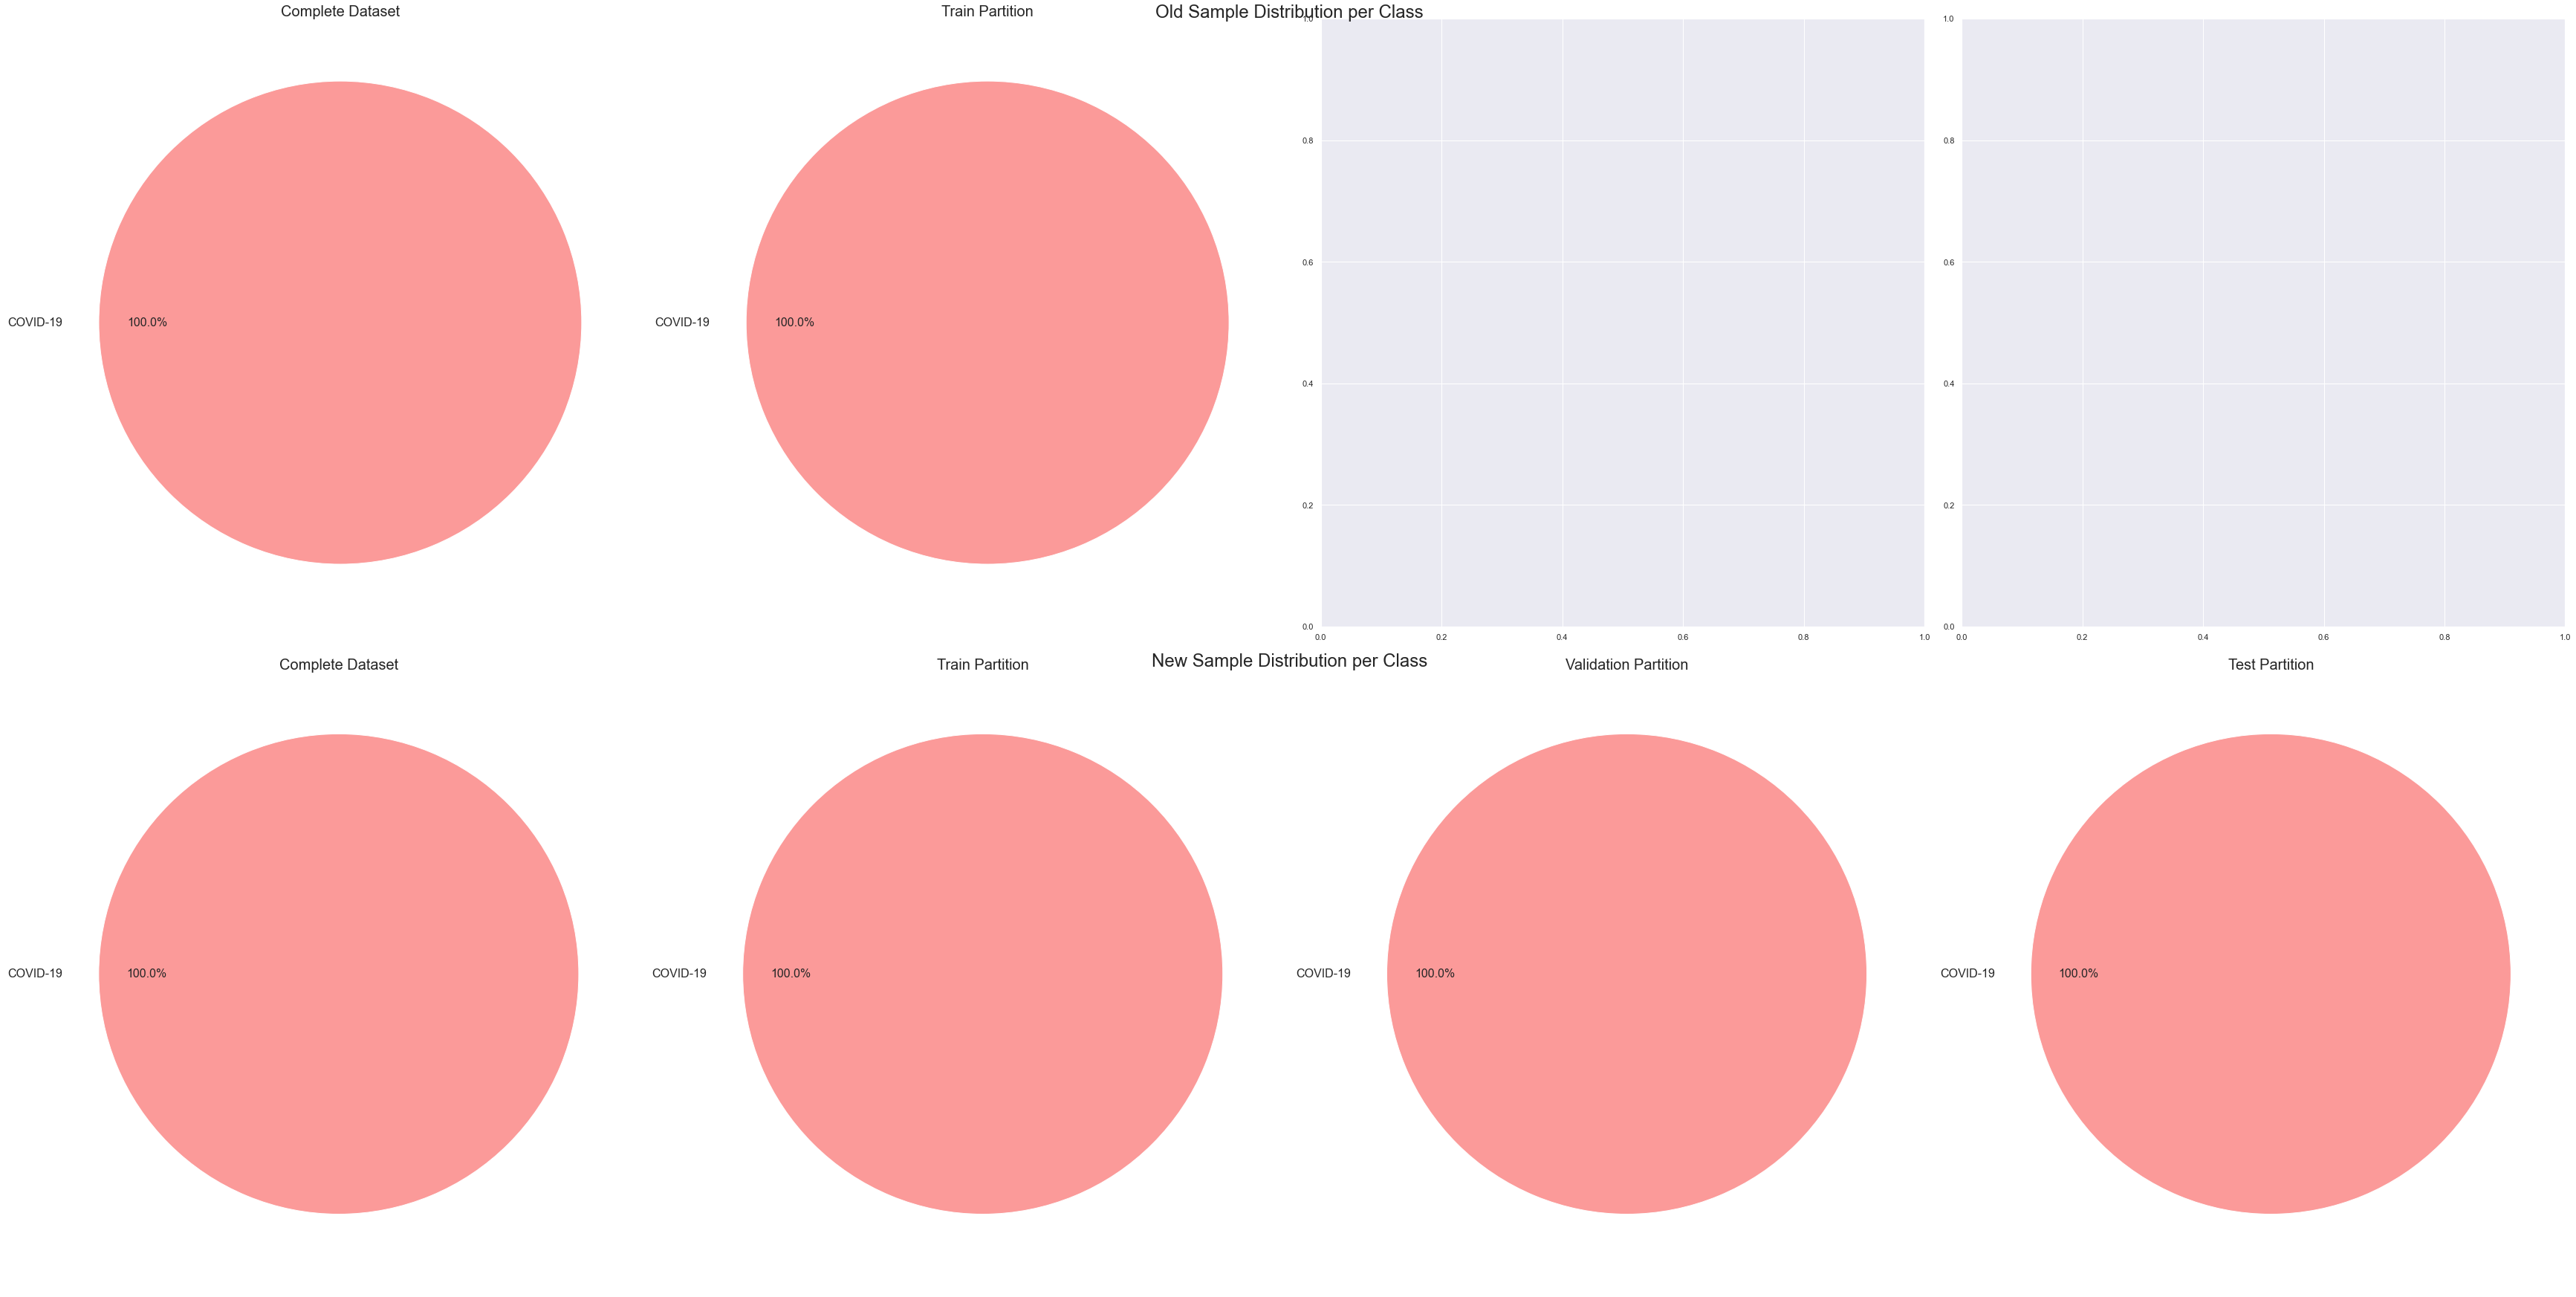

In [22]:
plot.column_as_pies( samples_df, new_samples_df, "class", dataset_name, figsize = (48, 24), resplit = True )

In [23]:
plot.column_as_table( samples_df, new_samples_df, "class", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
COVID-19,192361,192361,0,0
Normal,0,0,0,0
Pneumonia,0,0,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
COVID-19,192361,115417,38472,38472
SUM,192361,115417,38472,38472


## Age

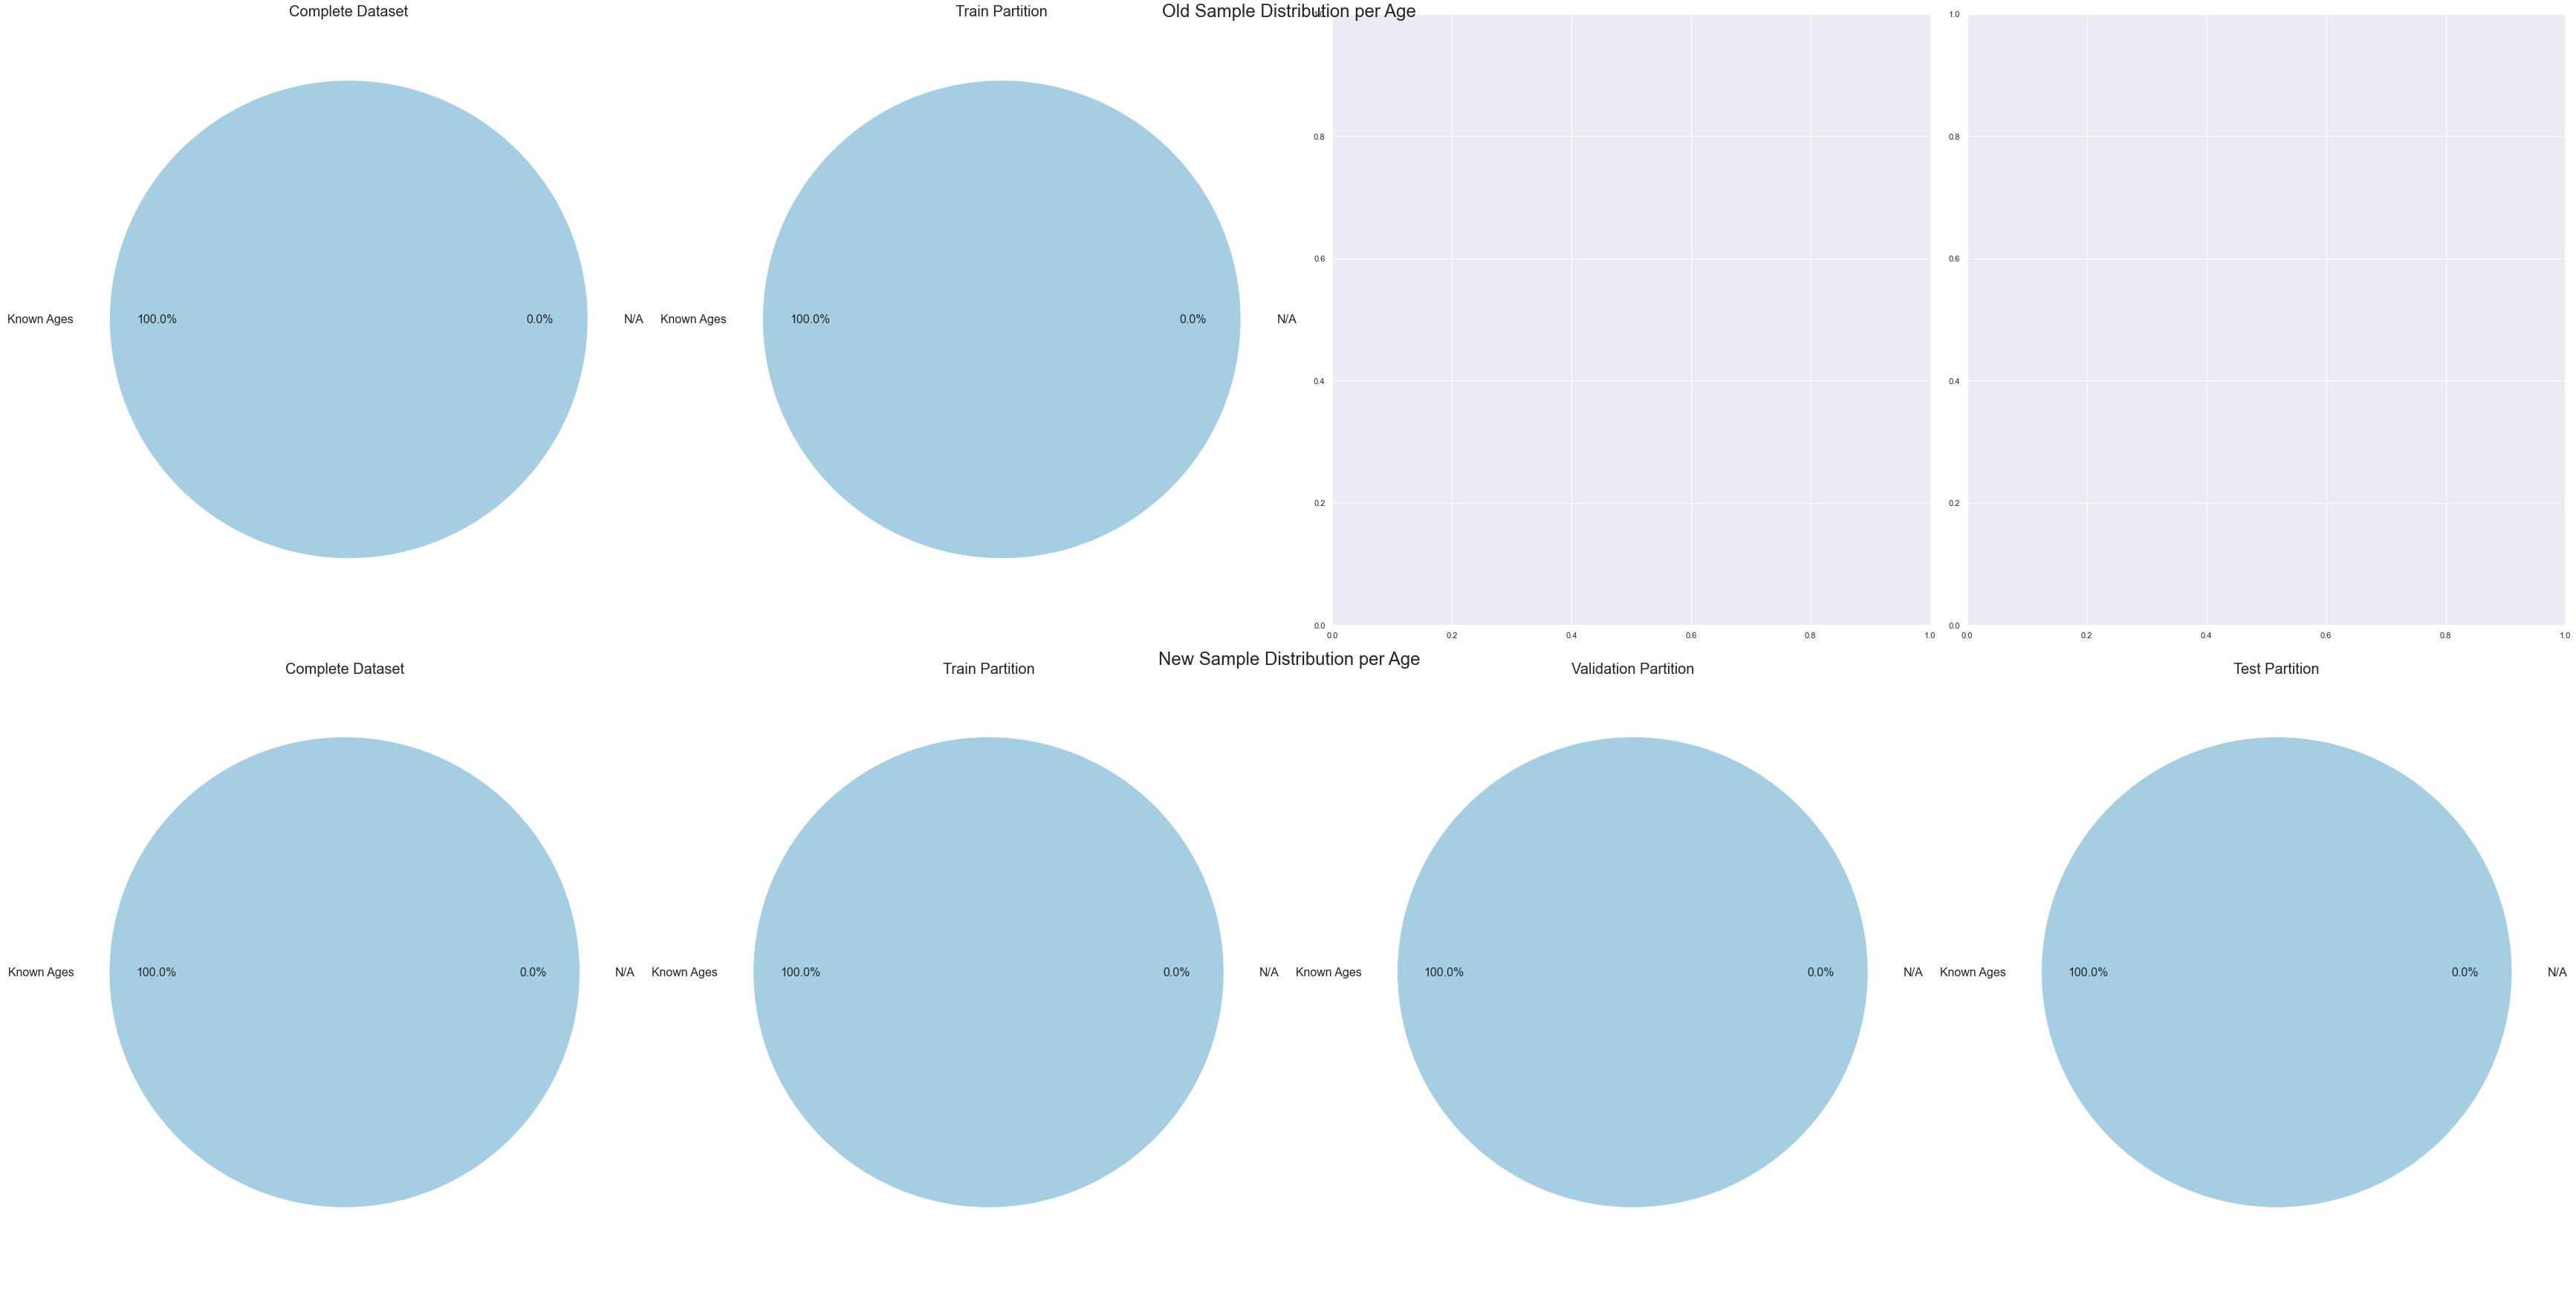

In [24]:
plot.column_as_pies( samples_df, new_samples_df, "age", dataset_name, figsize = (48, 24), resplit = True)

In [25]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
N/A,0,0,0,0
Known Ages,192361,192361,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
N/A,0,0,0,0
Known Ages,192361,115417,38472,38472
SUM,192361,115417,38472,38472


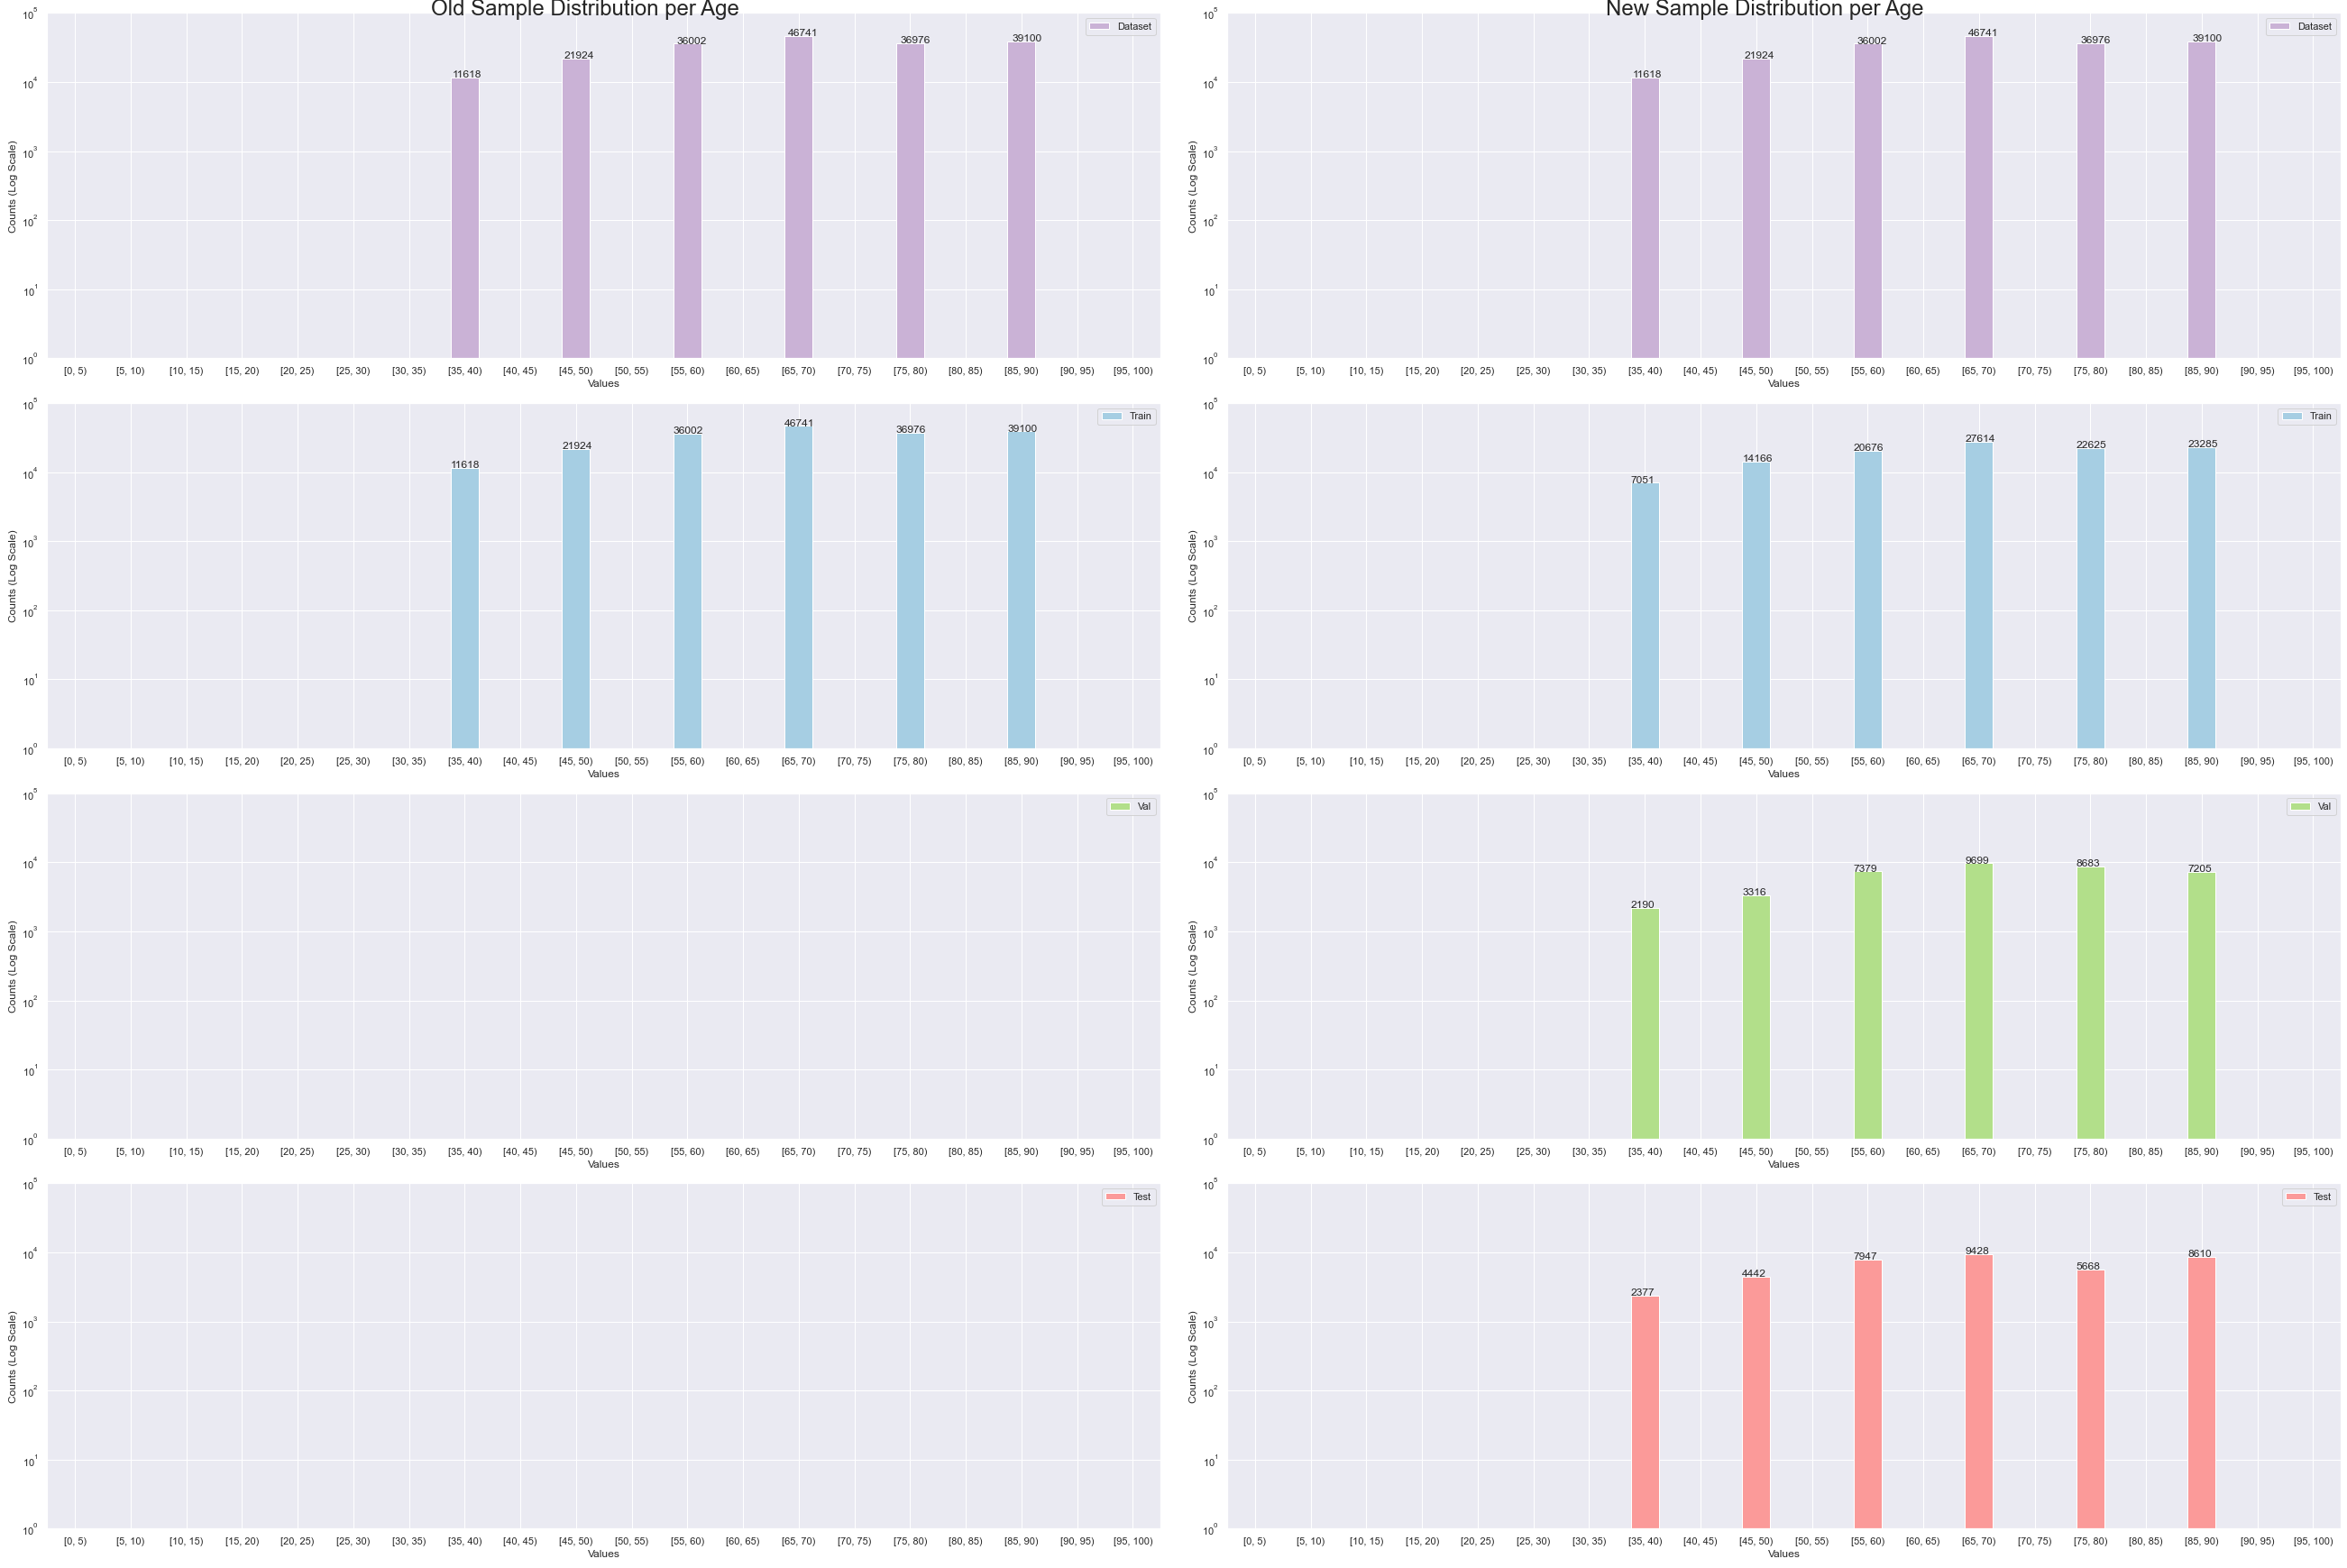

In [26]:
plot.column_as_histograms( samples_df, new_samples_df, "age", dataset_name, figsize = (36, 24), resplit = True)

In [27]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = True, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
"[0, 5)",0,0,0,0
"[5, 10)",0,0,0,0
"[10, 15)",0,0,0,0
"[15, 20)",0,0,0,0
"[20, 25)",0,0,0,0
"[25, 30)",0,0,0,0
"[30, 35)",0,0,0,0
"[35, 40)",11618,11618,0,0
"[40, 45)",0,0,0,0


## Sex

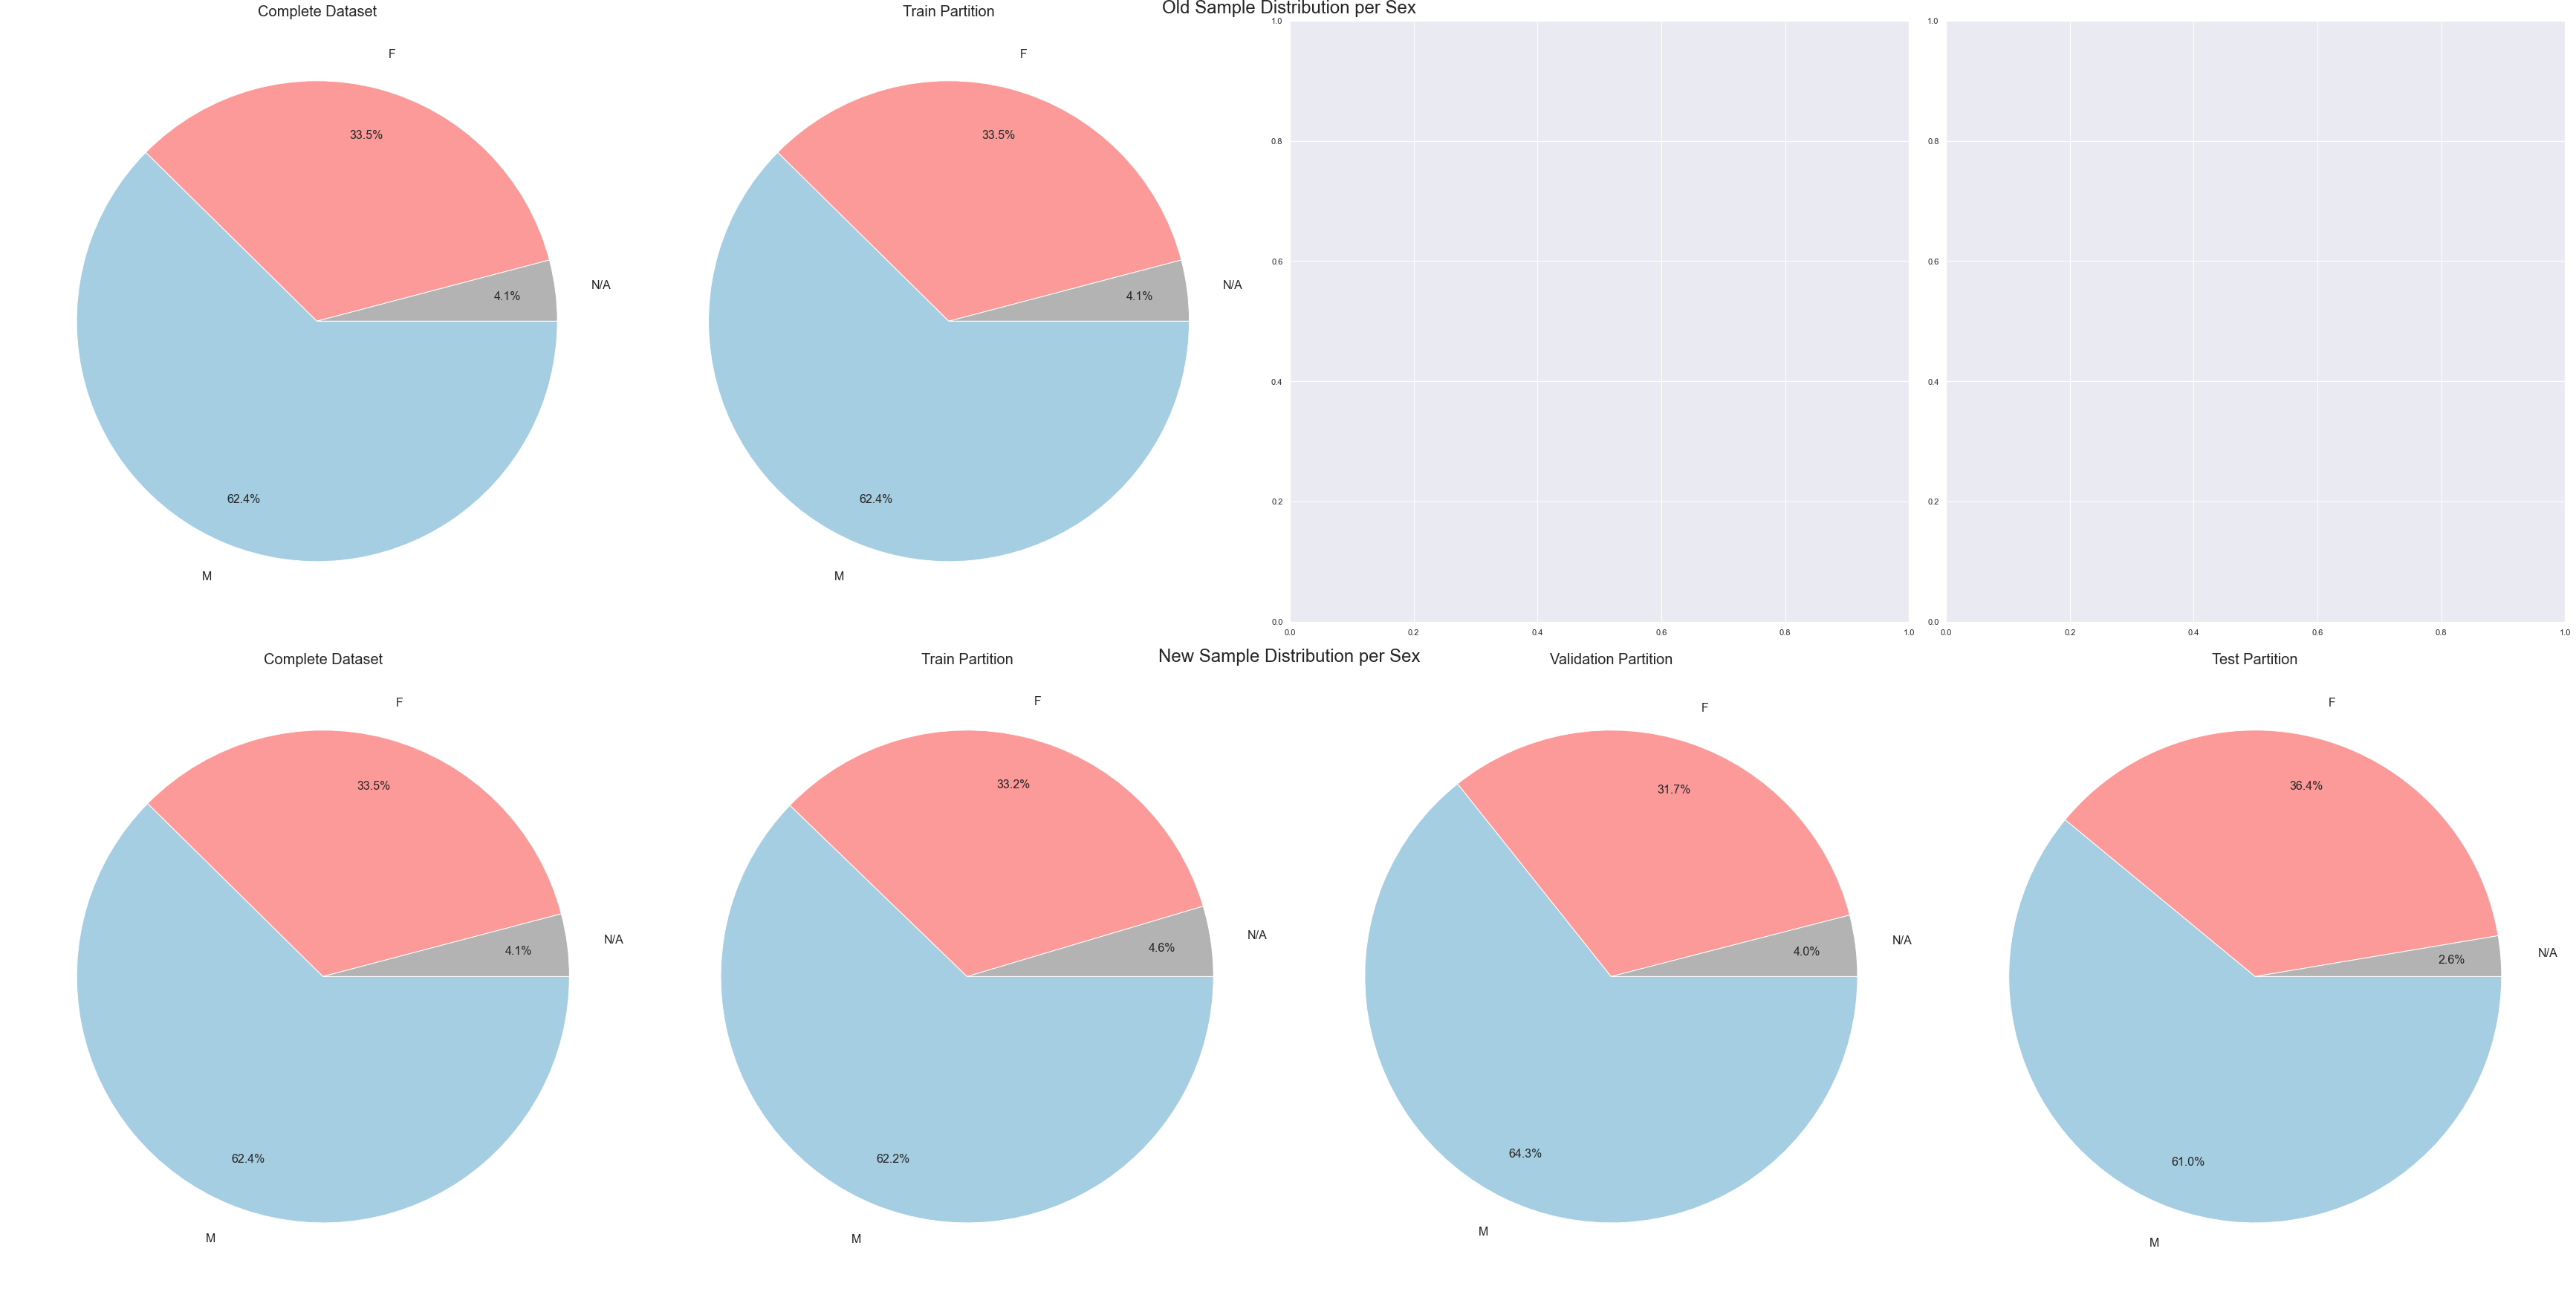

In [28]:
plot.column_as_pies( samples_df, new_samples_df, "sex", dataset_name, figsize = (48, 24), resplit = True )

In [29]:
plot.column_as_table( samples_df, new_samples_df, "sex", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
M,120016,120016,0,0
N/A,7879,7879,0,0
F,64466,64466,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
M,120016,71821,24735,23460
F,64466,38280,12193,13993
N/A,7879,5316,1544,1019


## Country

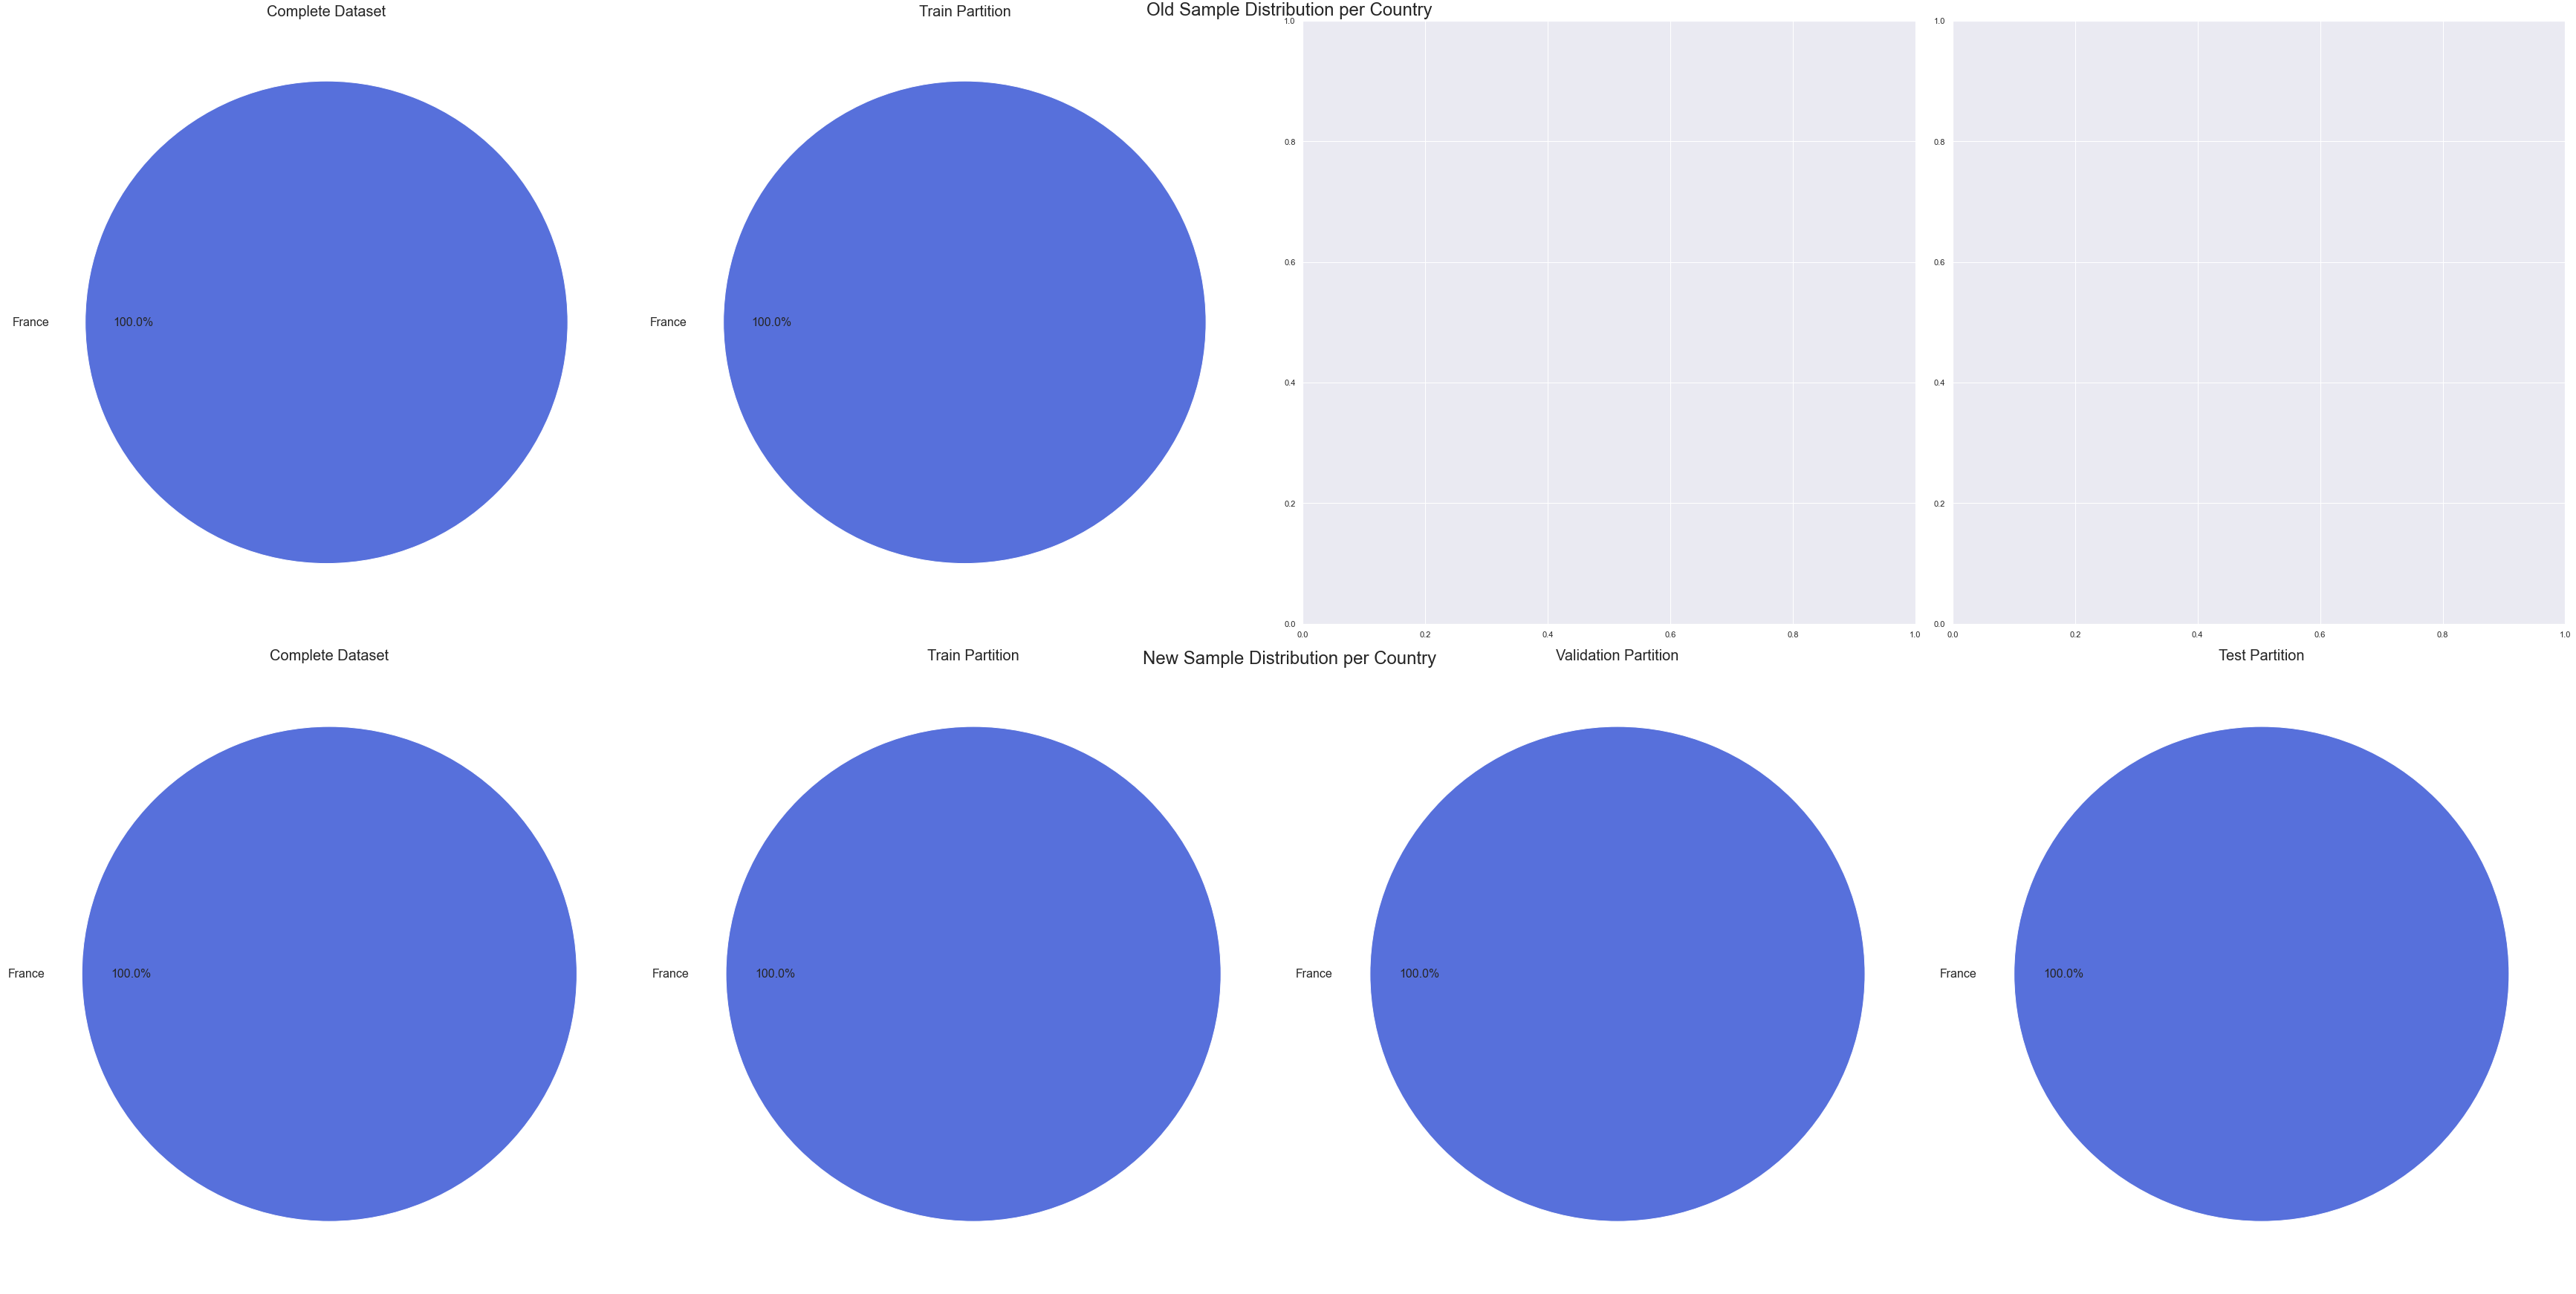

In [30]:
plot.column_as_pies( samples_df, new_samples_df, "country", dataset_name, figsize = (48, 24), resplit = True )

In [31]:
plot.column_as_table( samples_df, new_samples_df, "country", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
France,192361,192361,0,0
China,0,0,0,0
Iran,0,0,0,0
USA,0,0,0,0
N/A,0,0,0,0
Australia,0,0,0,0
Italy,0,0,0,0
Algeria,0,0,0,0
Belgium,0,0,0,0


## Partition

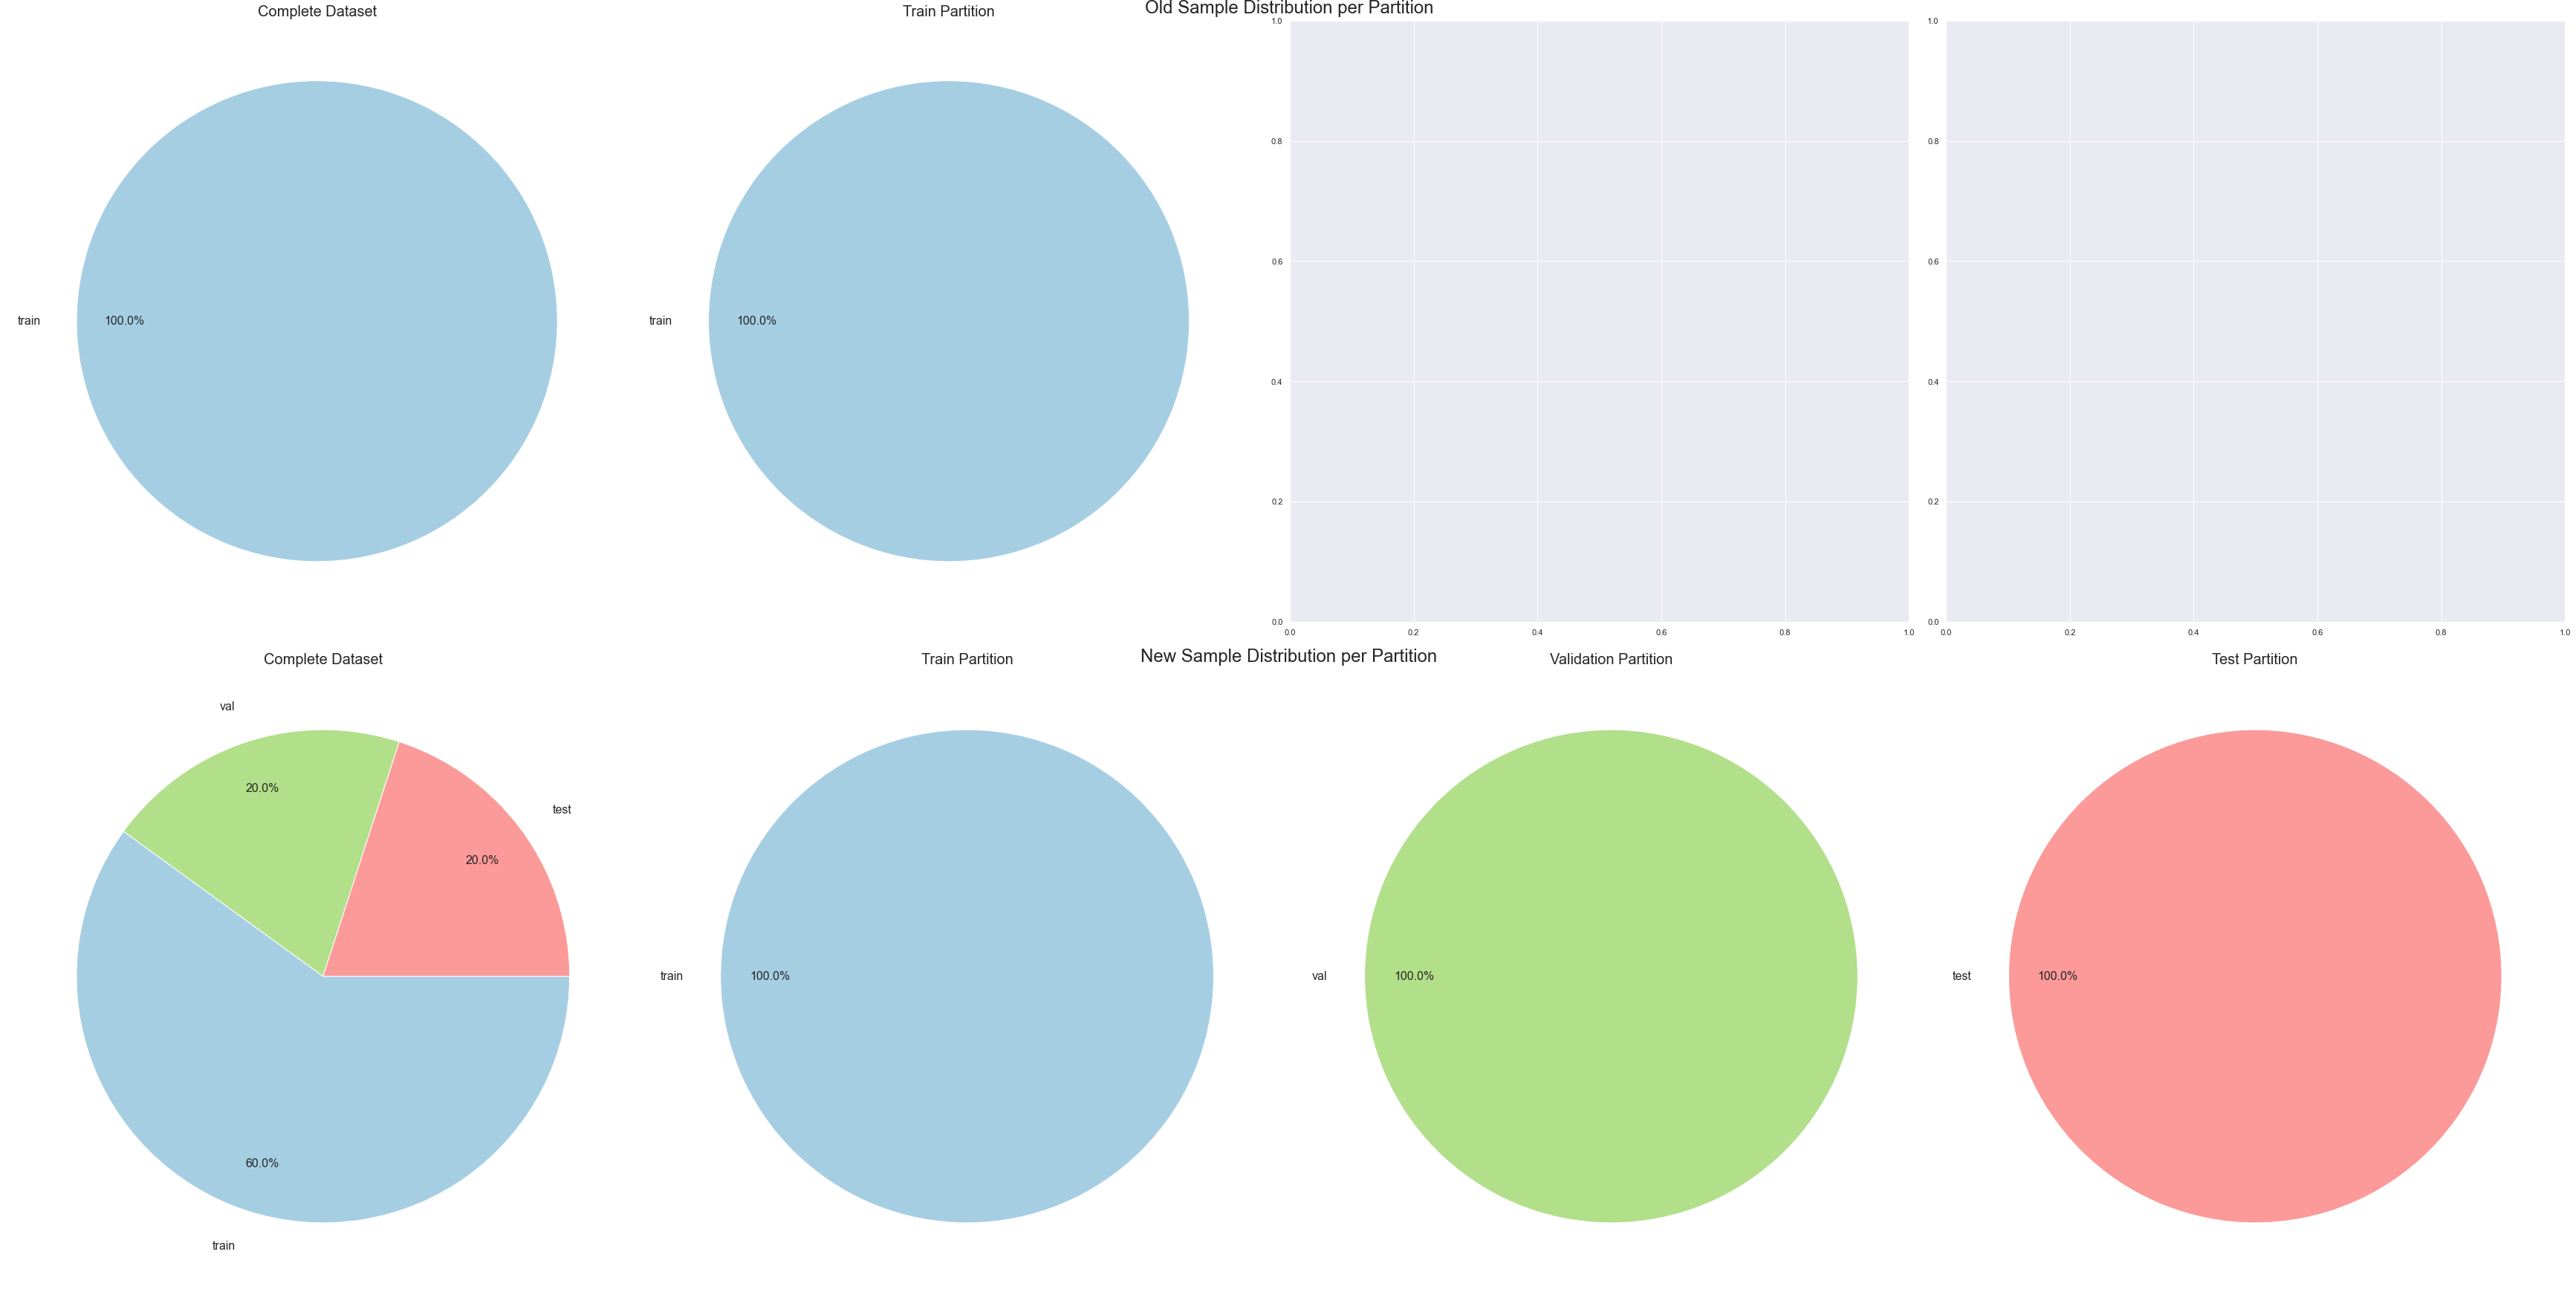

In [32]:
plot.column_as_pies( samples_df, new_samples_df, "partition", dataset_name, figsize = (48, 24), resplit = True )

In [33]:
plot.column_as_table( samples_df, new_samples_df, "partition", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
train,192361,192361,0,0
test,0,0,0,0
val,0,0,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
train,115417,115417,0,0
test,38472,0,0,38472
val,38472,0,38472,0


## Slice Selection

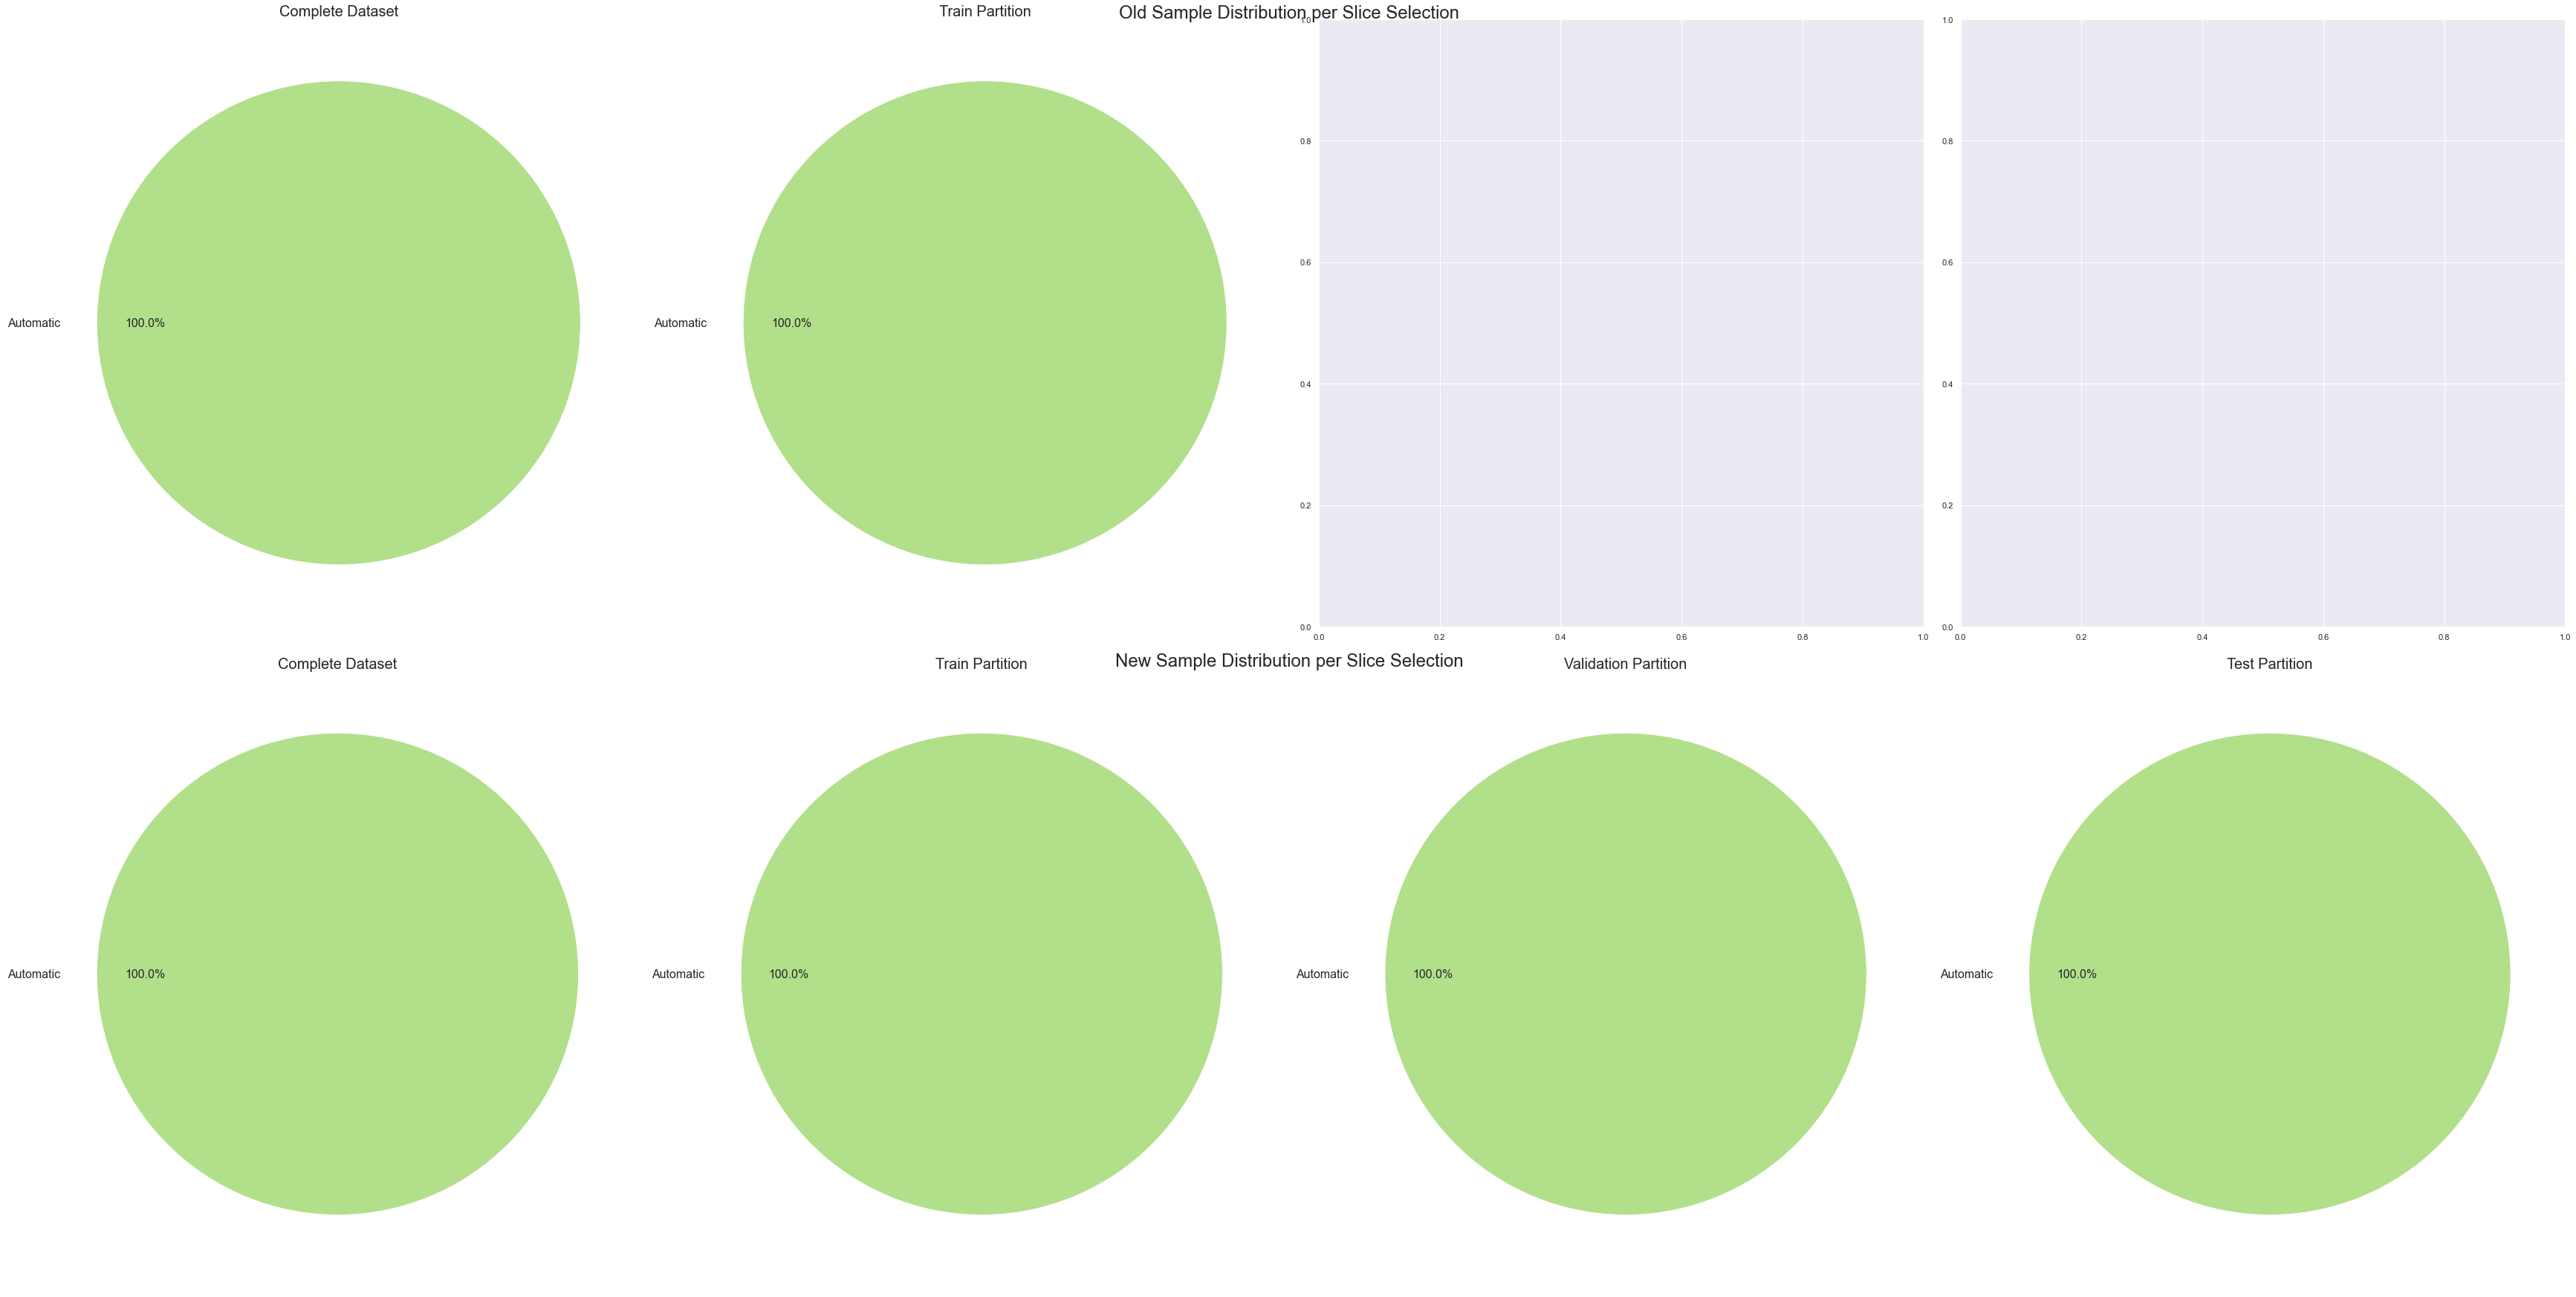

In [34]:
plot.column_as_pies( samples_df, new_samples_df, "slice_selection", dataset_name, figsize = (48, 24), resplit = True )

In [35]:
plot.column_as_table( samples_df, new_samples_df, "slice_selection", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
Automatic,192361,192361,0,0
Expert,0,0,0,0
N/A,0,0,0,0
Non-expert,0,0,0,0
SUM,192361,192361,0,0
,Dataset,Train,Val,Test
Values,,,,
Automatic,192361,115417,38472,38472
SUM,192361,115417,38472,38472


# Registering Changes

In [36]:
# Path to save new metadata csv
csv_export_path = os.path.join( data_dir, "new_split_metadata.csv" )

updated_df = split.update_metadata_csv( csv_export_path, new_samples_df, dataset_name, save_bool = True )
print( len(updated_df), len(new_samples_df) )
updated_df.head()

387283 192361


,filename,patient_id,source,class,country,sex,age,partition,slice_selection,x_min,y_min,x_max,y_max,verified_finding,view,modality
0,NCP_96_1328_0032.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,9,94,512,405,Yes,Axial,CT
1,NCP_96_1328_0035.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,106,512,405,Yes,Axial,CT
2,NCP_96_1328_0036.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,105,512,406,Yes,Axial,CT
3,NCP_96_1328_0037.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,104,512,406,Yes,Axial,CT
4,NCP_96_1328_0038.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,103,512,406,Yes,Axial,CT
